In [1]:
import numpy as np
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
from matplotlib.colors import Normalize, TwoSlopeNorm
import cmocean
import cartopy.crs as ccrs
import cartopy
import seaborn as sns
from matplotlib import rcParams, cycler
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm

from xeofs.xarray import EOF
import dask
import distributed

import scipy
from scipy import signal
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import geopandas as gpd
import pickle

/var/folders/6b/9ftjhcg16g19w33zvk7zd7mm0131yc/T/ipykernel_2020/2054948773.py:27: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# FIXIT: Jupyter Lab scheduler view for Dask not working
client = distributed.Client()
client

2024-02-02 09:06:26,866 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/6b/9ftjhcg16g19w33zvk7zd7mm0131yc/T/dask-worker-space/worker-5gvgyg28', purging
2024-02-02 09:06:26,867 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/6b/9ftjhcg16g19w33zvk7zd7mm0131yc/T/dask-worker-space/worker-_htr1237', purging
2024-02-02 09:06:26,868 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/6b/9ftjhcg16g19w33zvk7zd7mm0131yc/T/dask-worker-space/worker-_r_bjaai', purging
2024-02-02 09:06:26,869 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/6b/9ftjhcg16g19w33zvk7zd7mm0131yc/T/dask-worker-space/worker-tmunecuz', purging
2024-02-02 09:06:26,869 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/6b/9ftjhcg16g19w33zvk7zd7mm0131yc/T/dask-worker-space/worker-wqliydga', purging


<Client: 'tcp://127.0.0.1:50773' processes=5 threads=10, memory=16.00 GiB>

In [72]:

main_dir = Path.cwd().parent # Main directory path of project repository - all filepaths are relative to this

# File path directories
DIR_external = 'data/external/'
DIR_interim = 'data/interim/'


# DATASET FILEPATHS
# Basal melt observations from Paolo 2023
DIR_basalMeltObs = 'data/external/Paolo2023/'
# Ocean model output - E3SM (SORRMv2.1.ISMF), data received from Darin Comeau / Matt Hoffman at LANL
DIR_SORRMv21 = 'data/external/SORRMv2.1.ISMF/regridded_output/'

# DATA FILENAMES
FILE_MeltDraftObs = 'ANT_G1920V01_IceShelfMeltDraft.nc'
FILE_SORRMv21 = 'Regridded_SORRMv2.1.ISMF.FULL.nc'
FILE_SORRMv21_DETRENDED = 'SORRMv21_detrended.nc'
FILE_iceShelvesShape = 'iceShelves.geojson'

FILE_SORRMv21_CLEAN = 'sorrmv21_clean.nc'
FILE_SORRMv21_CLEAN_TS = 'SORRMv21_CLEAN_TS.nc'

# INTERIM GENERATED FILEPATHS
DIR_basalMeltObs_Interim = 'data/interim/Paolo2023/iceShelves_dedraft/iceShelfRegions/'
DIR_SORRMv21_Interim = 'data/interim/SORRMv2.1.ISMF/iceShelves_dedraft/iceShelfRegions/'


In [74]:
iceshelvesmask = gpd.read_file(main_dir / DIR_interim / 'iceShelves.geojson')

# Convert to south polar stereographic projection
#icems = iceshelvesmask.to_crs({'init': 'epsg:3031'}); # This has been deprecated
icems = iceshelvesmask.to_crs('epsg:3031');
crs = ccrs.SouthPolarStereo();

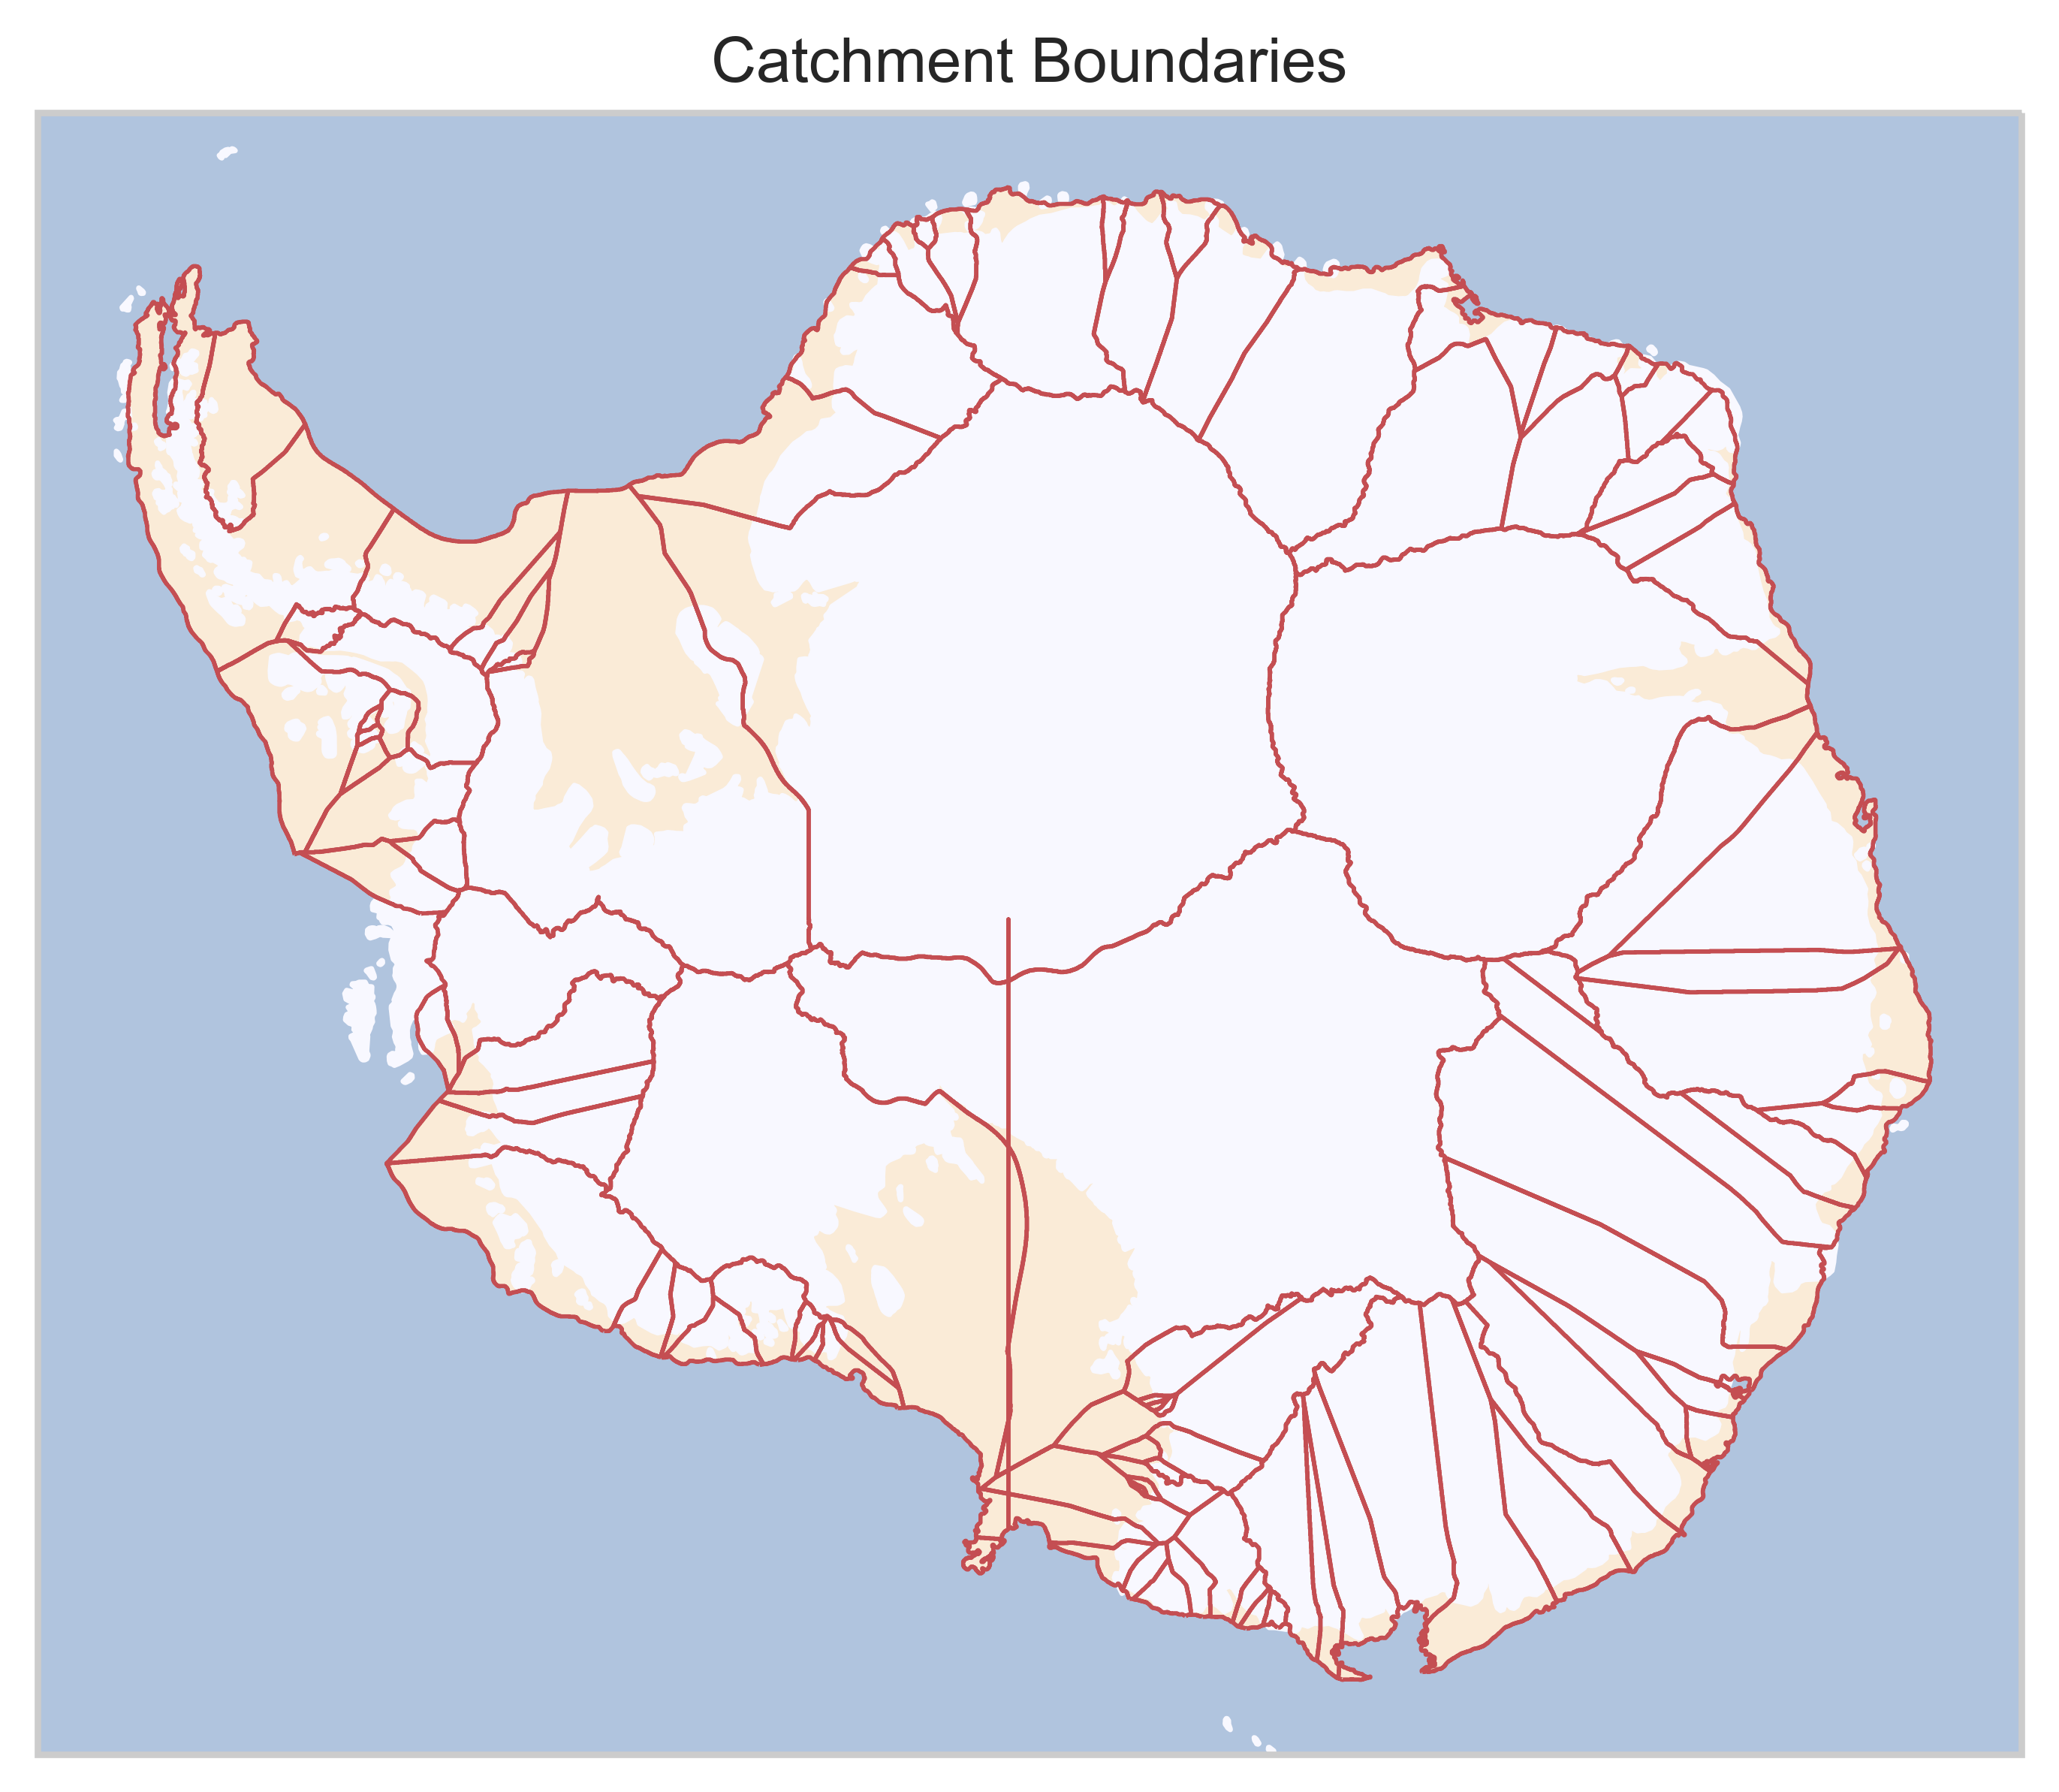

In [75]:
# Plot boundaries

sns.set_theme(style="whitegrid")

# dfs_issues.plot(ax=ax, zorder=2, label=label, markersize=50, marker='*', column='issue', categorical=True, cmap=cmap_new, legend=True)


plt.figure(figsize=(15,15),dpi=500)
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
#ax1.gridlines(color='whitesmoke',zorder=4)
icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
icems[34:133].boundary.plot(ax=ax1,color='r', linewidth=0.8,zorder=3)


ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite')
ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=2)
plt.title('Catchment Boundaries');

In [4]:
sorrmv21 = xr.open_dataset(main_dir / DIR_SORRMv21_Interim / FILE_SORRMv21_CLEAN,  chunks={"Time":36})
sorrmv21_ts = xr.open_dataset(main_dir / DIR_SORRMv21_Interim / FILE_SORRMv21_CLEAN_TS)

In [5]:
# Deseasonalized, detrended, dedrafted flux variable
yr1 = 100 # First 250 years removed as spinup 
yr2 = 900 # Assume as end point for now, computational reasons
# TODO : Change code to extract full dataset starting yr 100 onwards

flux_clean = sorrmv21.__xarray_dataarray_variable__[yr1*12:yr2*12]
flux_clean_ts = sorrmv21_ts.__xarray_dataarray_variable__[yr1*12:yr2*12]

In [51]:
flux_clean_annual = flux_clean.resample(Time='1Y').mean()
flux_clean_annual_ts = flux_clean_ts.resample(Time='1Y').mean()

## Dataset statistics
Look at these measures for the full dataset first.
- Range ?
- Interquartile range ?
- Amplitude
- Standard deviation
- Auto-correlation time
- Peak period in the Fourier spectrum
- Spatial autocorrelation

In [7]:
# Variance: time and space

flux_clean_var = flux_clean.var(dim='Time').compute()
flux_clean_tvar = flux_clean.var(dim=['x','y']).compute()

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [15]:
flux_clean_tvar_coarse = flux_clean_tvar.coarsen(Time=12).mean()

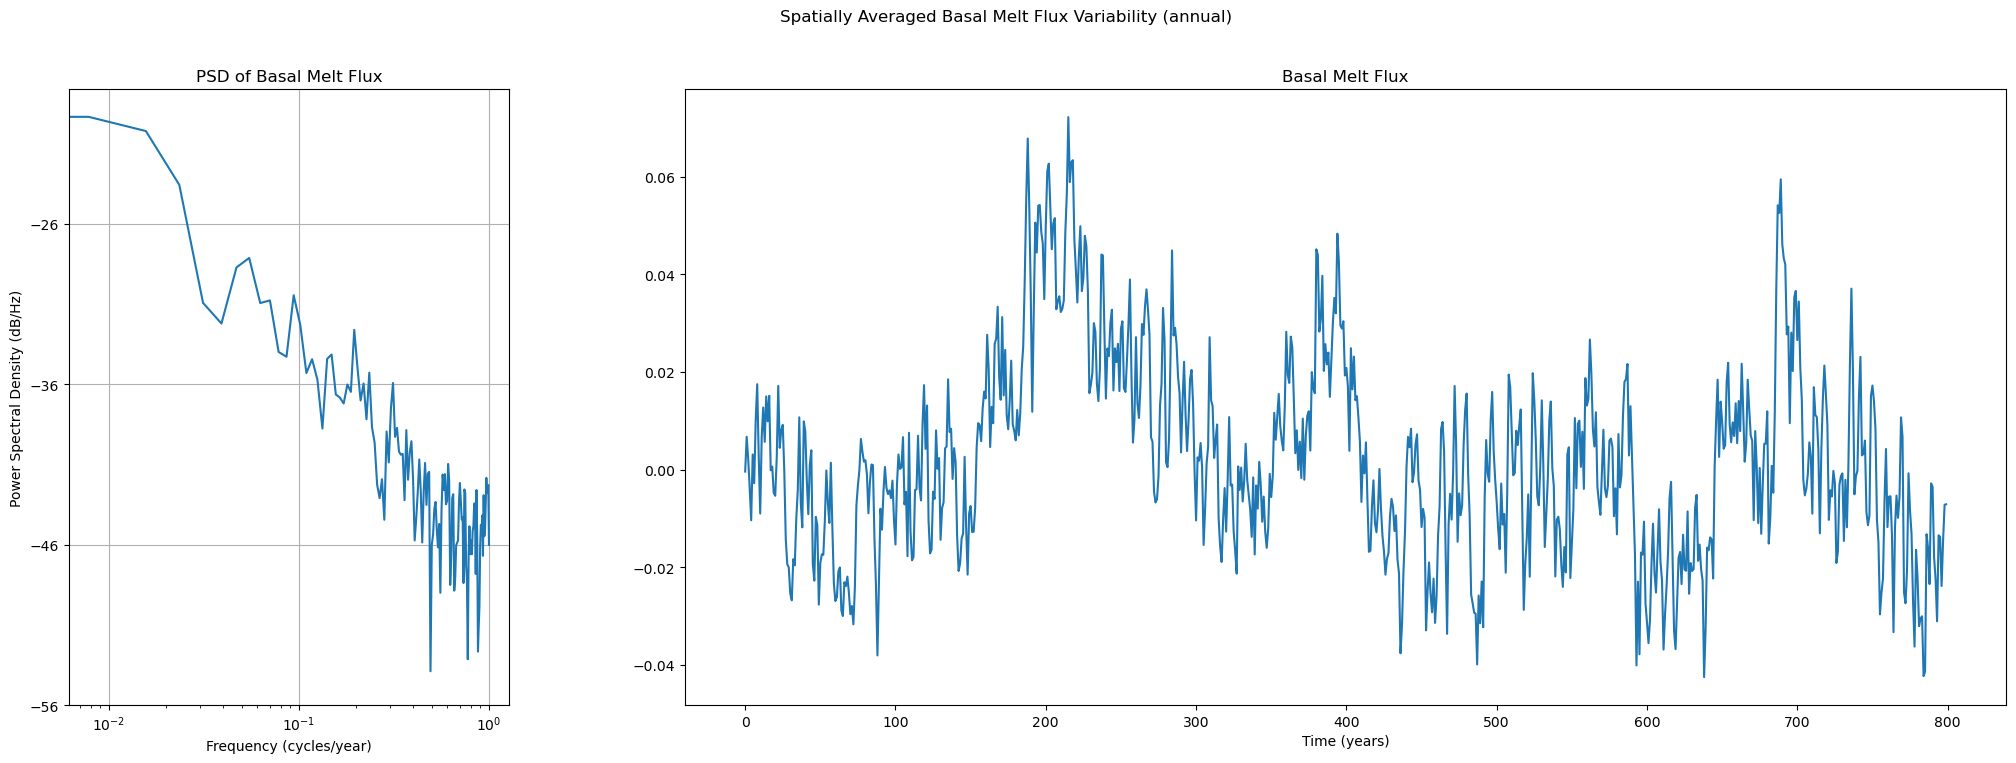

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(25, 8), gridspec_kw={'width_ratios': [1, 3]})

axs[0].psd(flux_clean_annual_ts);
axs[0].set_xlabel('Frequency (cycles/year)')
axs[0].set_xscale('log')
axs[0].set_title('PSD of Basal Melt Flux')

axs[1].plot(flux_clean_annual_ts)
axs[1].set_xlabel('Time (years)')
axs[1].set_title('Basal Melt Flux')

fig.suptitle('Spatially Averaged Basal Melt Flux Variability (annual)')
plt.show()

In [70]:
#modified to not return f - in calculation of RMSE, only Px required
def psd_calc_grid(data,y,x):
    f, Px = scipy.signal.welch(data[:,y,x])
    return Px

def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping))
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    #clipped_data = clipped_data.drop("month")
    return clipped_data

Text(0.5, 0, 'Time (years)')

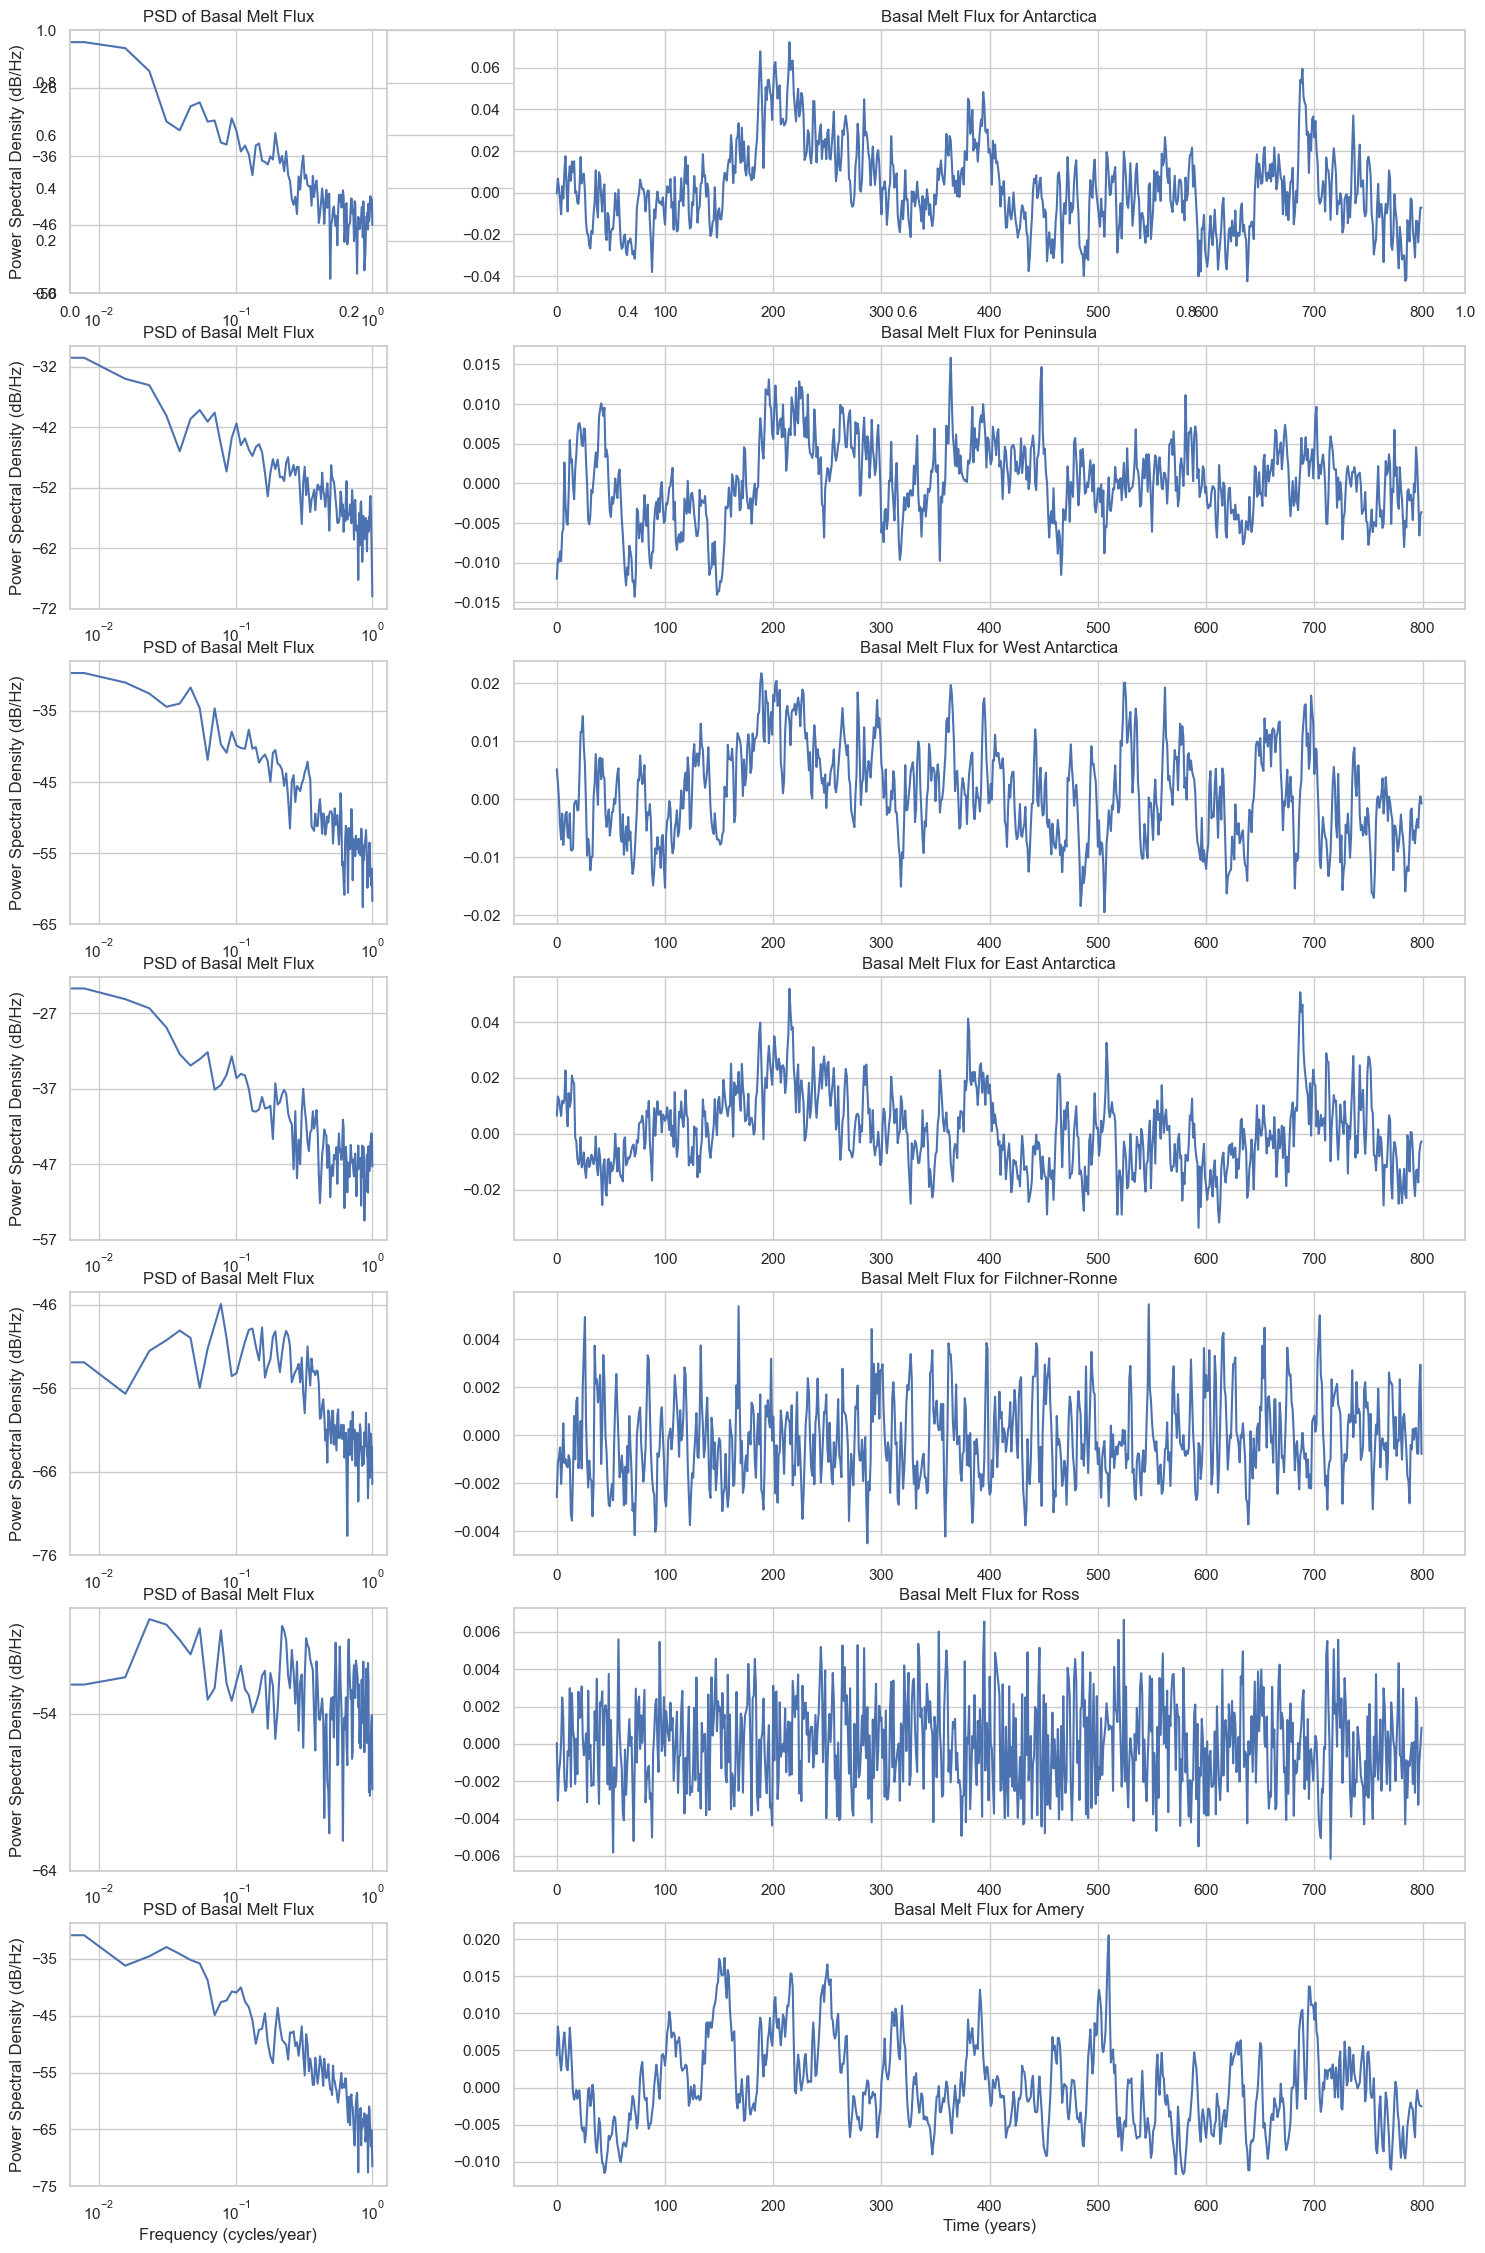

In [103]:
# [2,3,4,5] = [Antarctica, Peninsula, West Antarctica, East Antarctica]
basins = np.array([2,3,4,5,0,1,34])

n_basins = len(basins)

sns.set_theme(style="whitegrid")
fig=plt.figure(figsize=(18,4*n_basins))
gs = GridSpec(n_basins, 2, width_ratios=[1,3])
axtop = fig.add_subplot(gs[0, :])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(n_basins)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(n_basins)]

for i,(a0,a1) in enumerate(zip(ax0,ax1)):
    basin_flux_clean_annual = clip_data(flux_clean_annual, basins[i]).compute()
    basin_flux_clean_annual_ts = time_series(basin_flux_clean_annual).compute()
    a0.psd(basin_flux_clean_annual_ts);
    a0.set_xlabel('')
    a0.set_xscale('log')
    a0.set_title('PSD of Basal Melt Flux')
    a1.plot(basin_flux_clean_annual_ts)
    a0.set_xlabel('')
    a1.set_title('Basal Melt Flux for {}'.format(icems.loc[basins[i],'name']))

a0.set_xlabel('Frequency (cycles/year)')
a1.set_xlabel('Time (years)')

In [110]:
flux_clean_spatial_mean = flux_clean.mean(['Time']).compute()

In [114]:
vminflux = np.nanquantile(flux_clean_spatial_mean[:], 0.01)
vmaxflux = np.nanquantile(flux_clean_spatial_mean[:], 0.99)

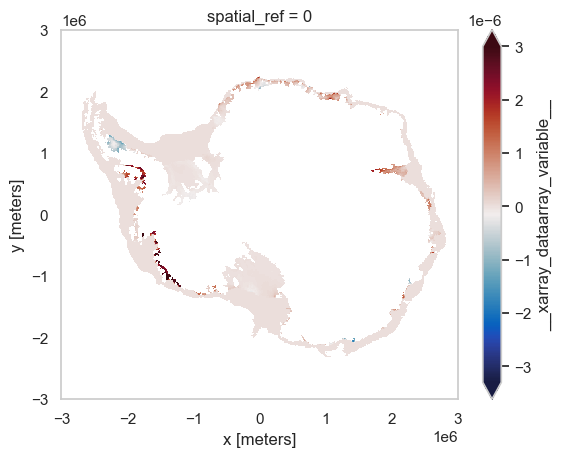

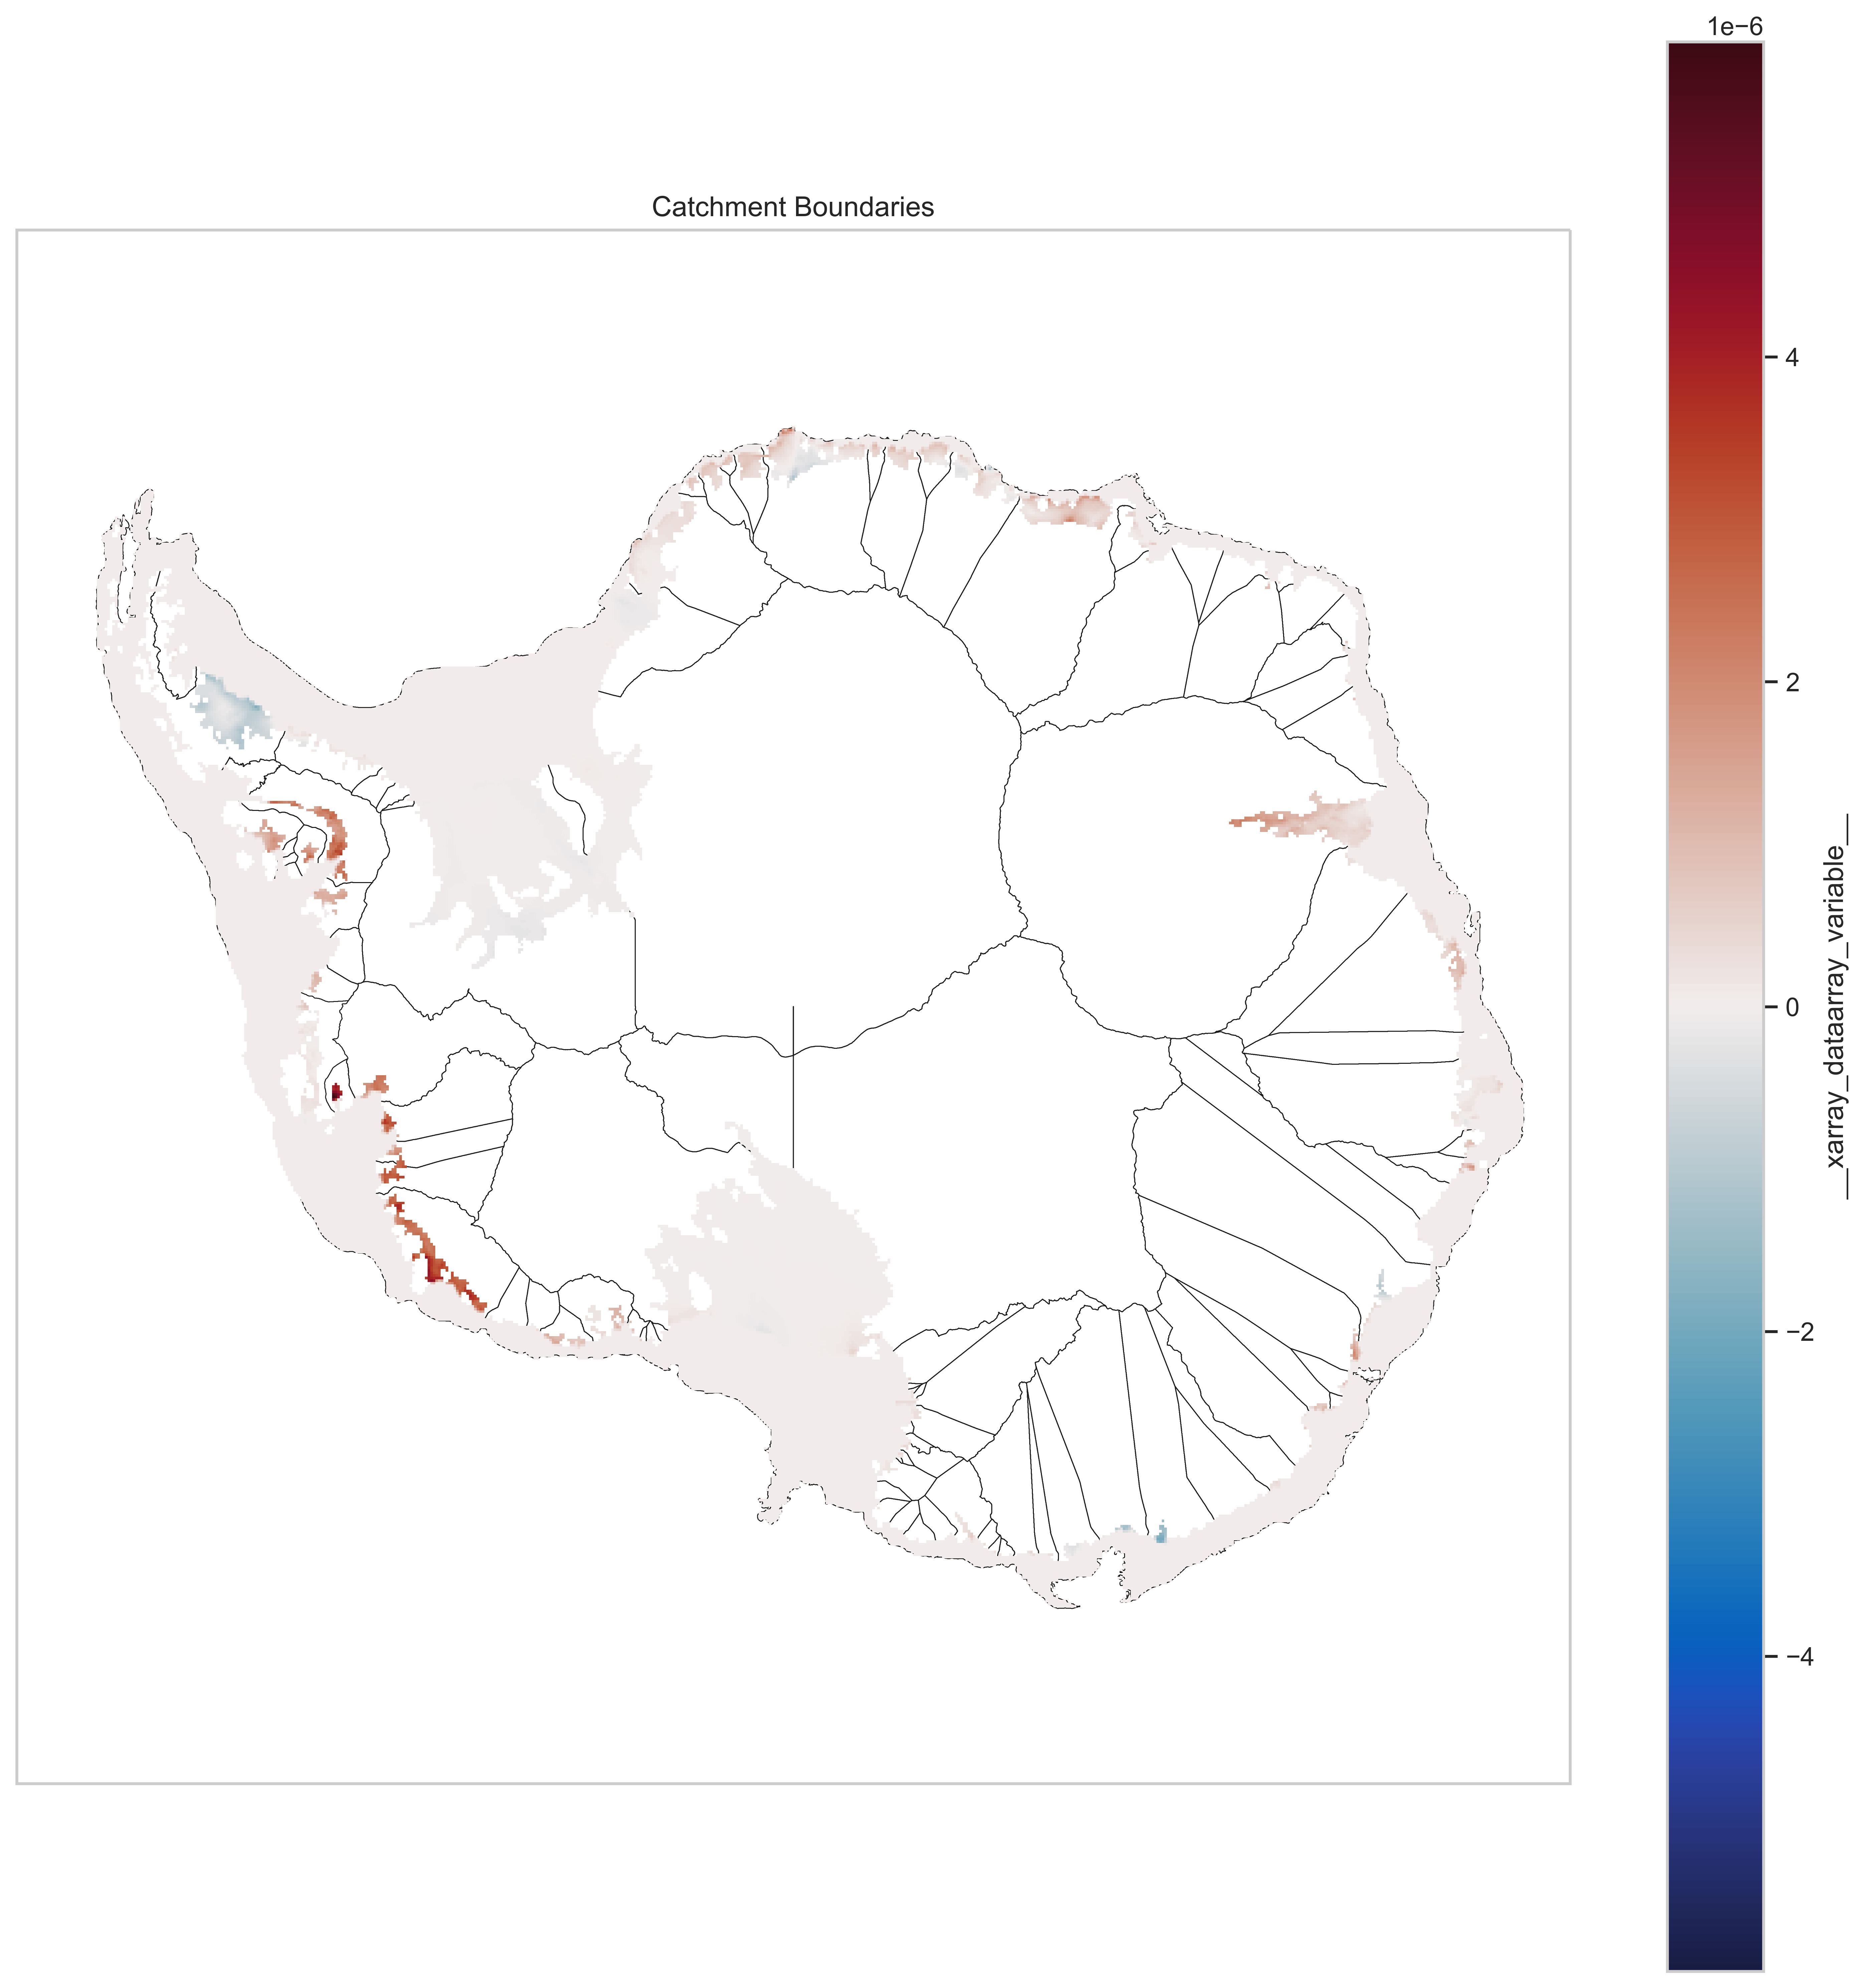

In [129]:
# Plot boundaries

sns.set_theme(style="whitegrid")

# dfs_issues.plot(ax=ax, zorder=2, label=label, markersize=50, marker='*', column='issue', categorical=True, cmap=cmap_new, legend=True)

plt.figure(figsize=(15,15),dpi=500)
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())
#ax1.gridlines(color='whitesmoke',zorder=4)
#icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
icems[34:133].boundary.plot(ax=ax1,color='k', linewidth=0.4,zorder=1)
flux_clean_spatial_mean.plot(cmap=cmocean.cm.balance)

#ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=2)
plt.title('Catchment Boundaries');

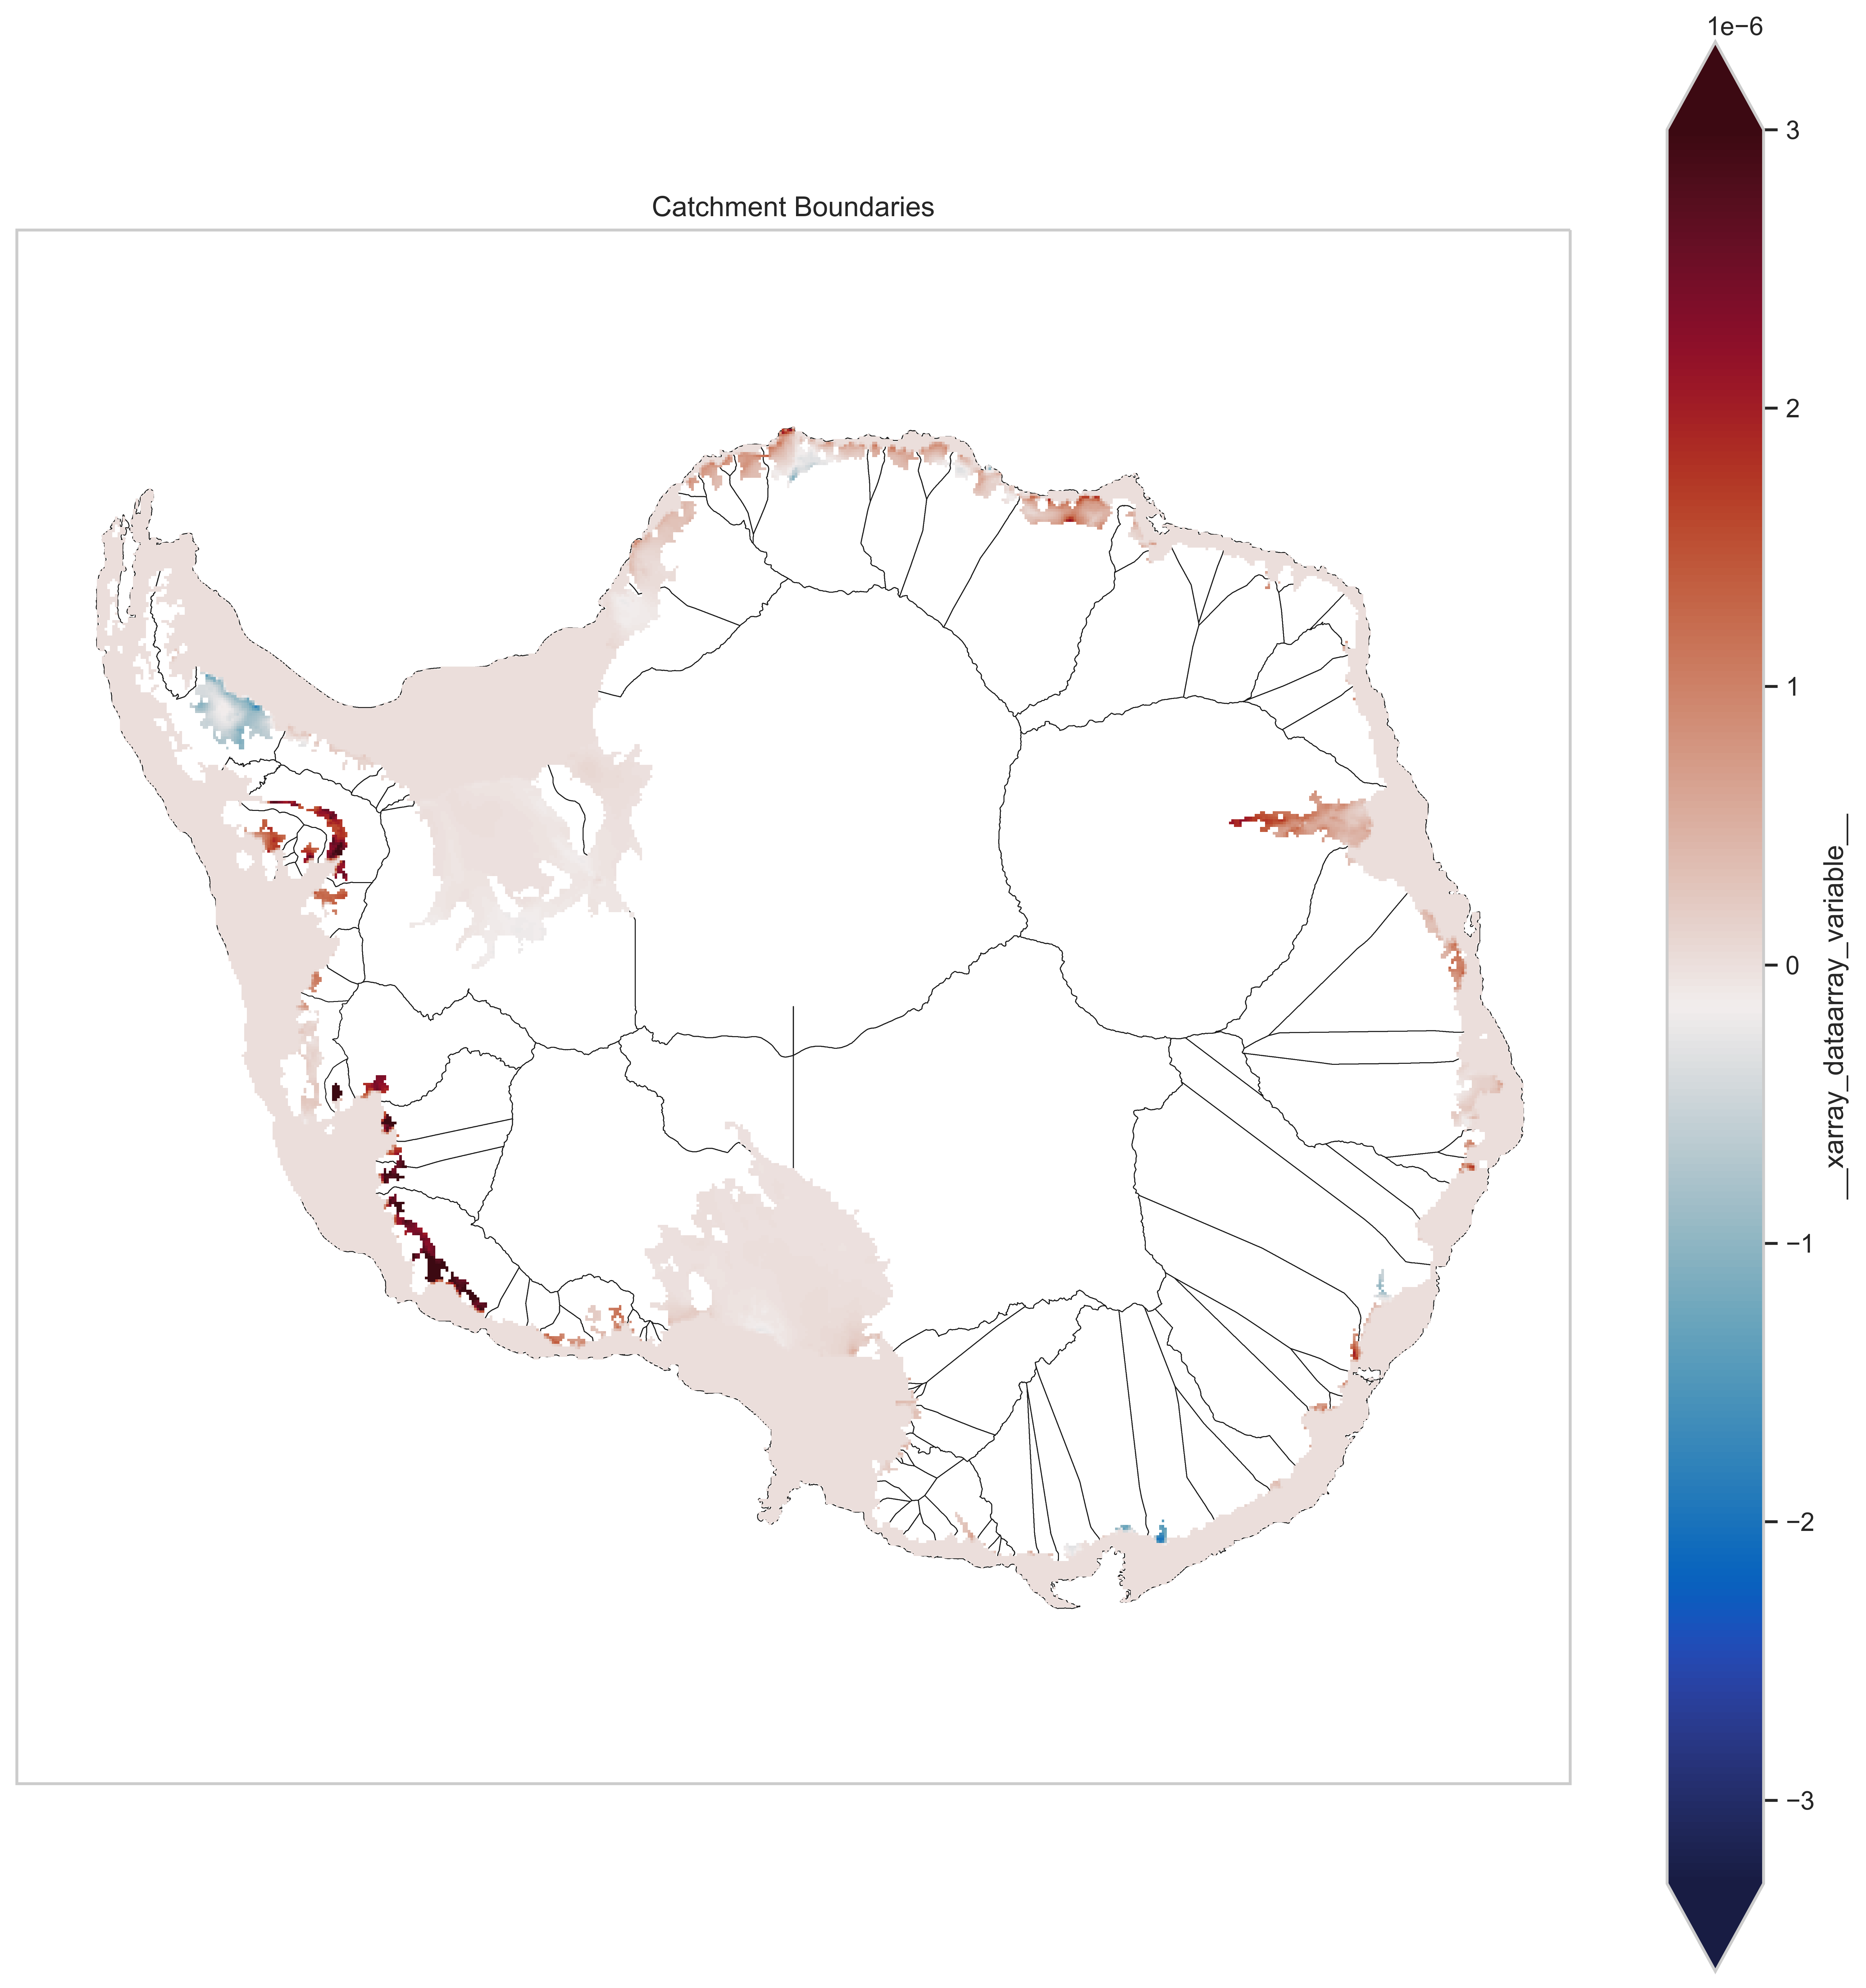

In [128]:
# Plot boundaries

sns.set_theme(style="whitegrid")

# dfs_issues.plot(ax=ax, zorder=2, label=label, markersize=50, marker='*', column='issue', categorical=True, cmap=cmap_new, legend=True)

plt.figure(figsize=(15,15),dpi=500)
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())
#ax1.gridlines(color='whitesmoke',zorder=4)
#icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
icems[34:133].boundary.plot(ax=ax1,color='k', linewidth=0.4,zorder=1)
flux_clean_spatial_mean.plot(vmin=3e-6, vmax=-3e-6, cmap=cmocean.cm.balance)

#ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=2)
plt.title('Catchment Boundaries');

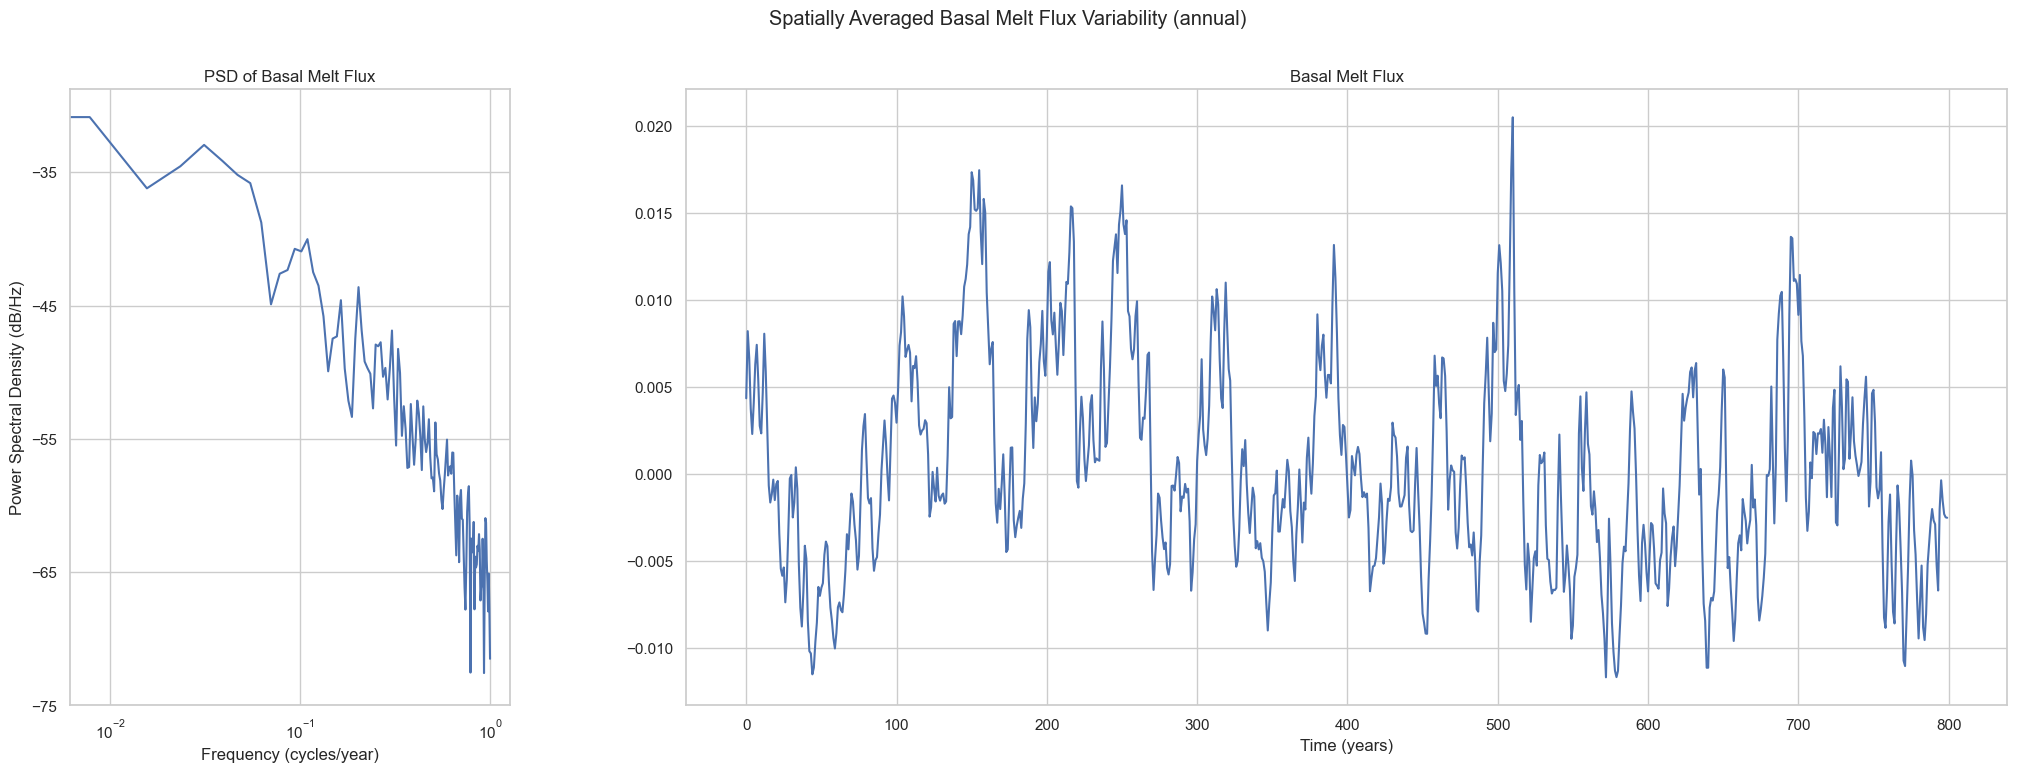

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(25, 8), gridspec_kw={'width_ratios': [1, 3]})

axs[0].psd(basin_flux_clean_annual_ts);
axs[0].set_xlabel('Frequency (cycles/year)')
axs[0].set_xscale('log')
axs[0].set_title('PSD of Basal Melt Flux')

axs[1].plot(basin_flux_clean_annual_ts)
axs[1].set_xlabel('Time (years)')
axs[1].set_title('Basal Melt Flux')

fig.suptitle('Spatially Averaged Basal Melt Flux Variability (annual)')
plt.show()

In [11]:
# Normalize 
flux_clean_tmean = flux_clean.mean('Time').compute()
flux_clean_tstd = flux_clean.std('Time').compute()
flux_clean_demeaned = flux_clean - flux_clean_tmean
flux_clean_normalized = flux_clean_demeaned/flux_clean_tstd

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


## EOF Decomposition

In [18]:
# Rename Time dimension from 'Time' to 'time'
flux_clean = flux_clean.rename({'Time':'time'})

In [20]:
# Non-normalized variability decomposition 
model = EOF(flux_clean)
model.solve()
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
varexpl = model.explained_variance_ratio()
pcs_eig = model.pcs(1)


2024-02-01 00:37:54,959 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:63178', name: 3, status: running, memory: 0, processing: 0>
2024-02-01 00:37:55,000 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:63180', name: 2, status: running, memory: 0, processing: 0>
2024-02-01 00:37:55,707 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:63182', name: 0, status: running, memory: 0, processing: 0>
2024-02-01 00:37:55,713 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:63182'.
2024-02-01 00:37:55,714 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:63178'.
2024-02-01 00:37:55,717 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:631

In [33]:
file_pi = open(str(main_dir / "data/interim/SORRMv2.1.ISMF/" / "model.obj"), 'wb')
pickle.dump(model, file_pi)
file_pi.close()

In [8]:
file_pi = open(str(main_dir / "data/interim/SORRMv2.1.ISMF/" / "model.obj"), 'rb')
model = pickle.load(file_pi)

eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
varexpl = model.explained_variance_ratio()

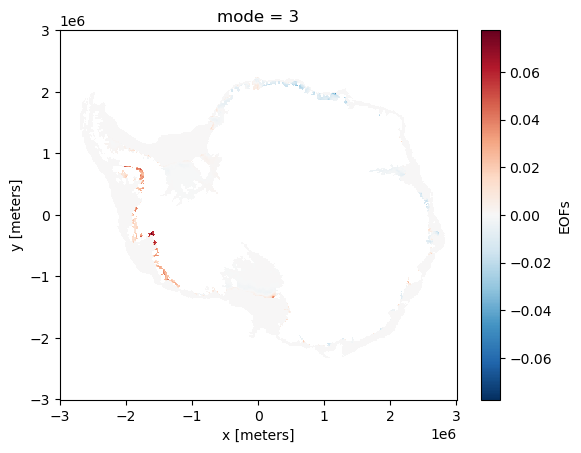

In [12]:
eofs[:,:,2].plot()

In [13]:
file_pi2 = open(str(main_dir / "data/interim/SORRMv2.1.ISMF/" / "norm_model.obj"), 'rb')
norm_model = pickle.load(file_pi2)

# Normalized variability decomposition 
#norm_model = EOF(flux_clean_normalized)
#norm_model.solve()
norm_eofs = norm_model.eofs()
norm_pcs = norm_model.pcs()
norm_nmodes = norm_model.n_modes
norm_varexpl = norm_model.explained_variance_ratio()

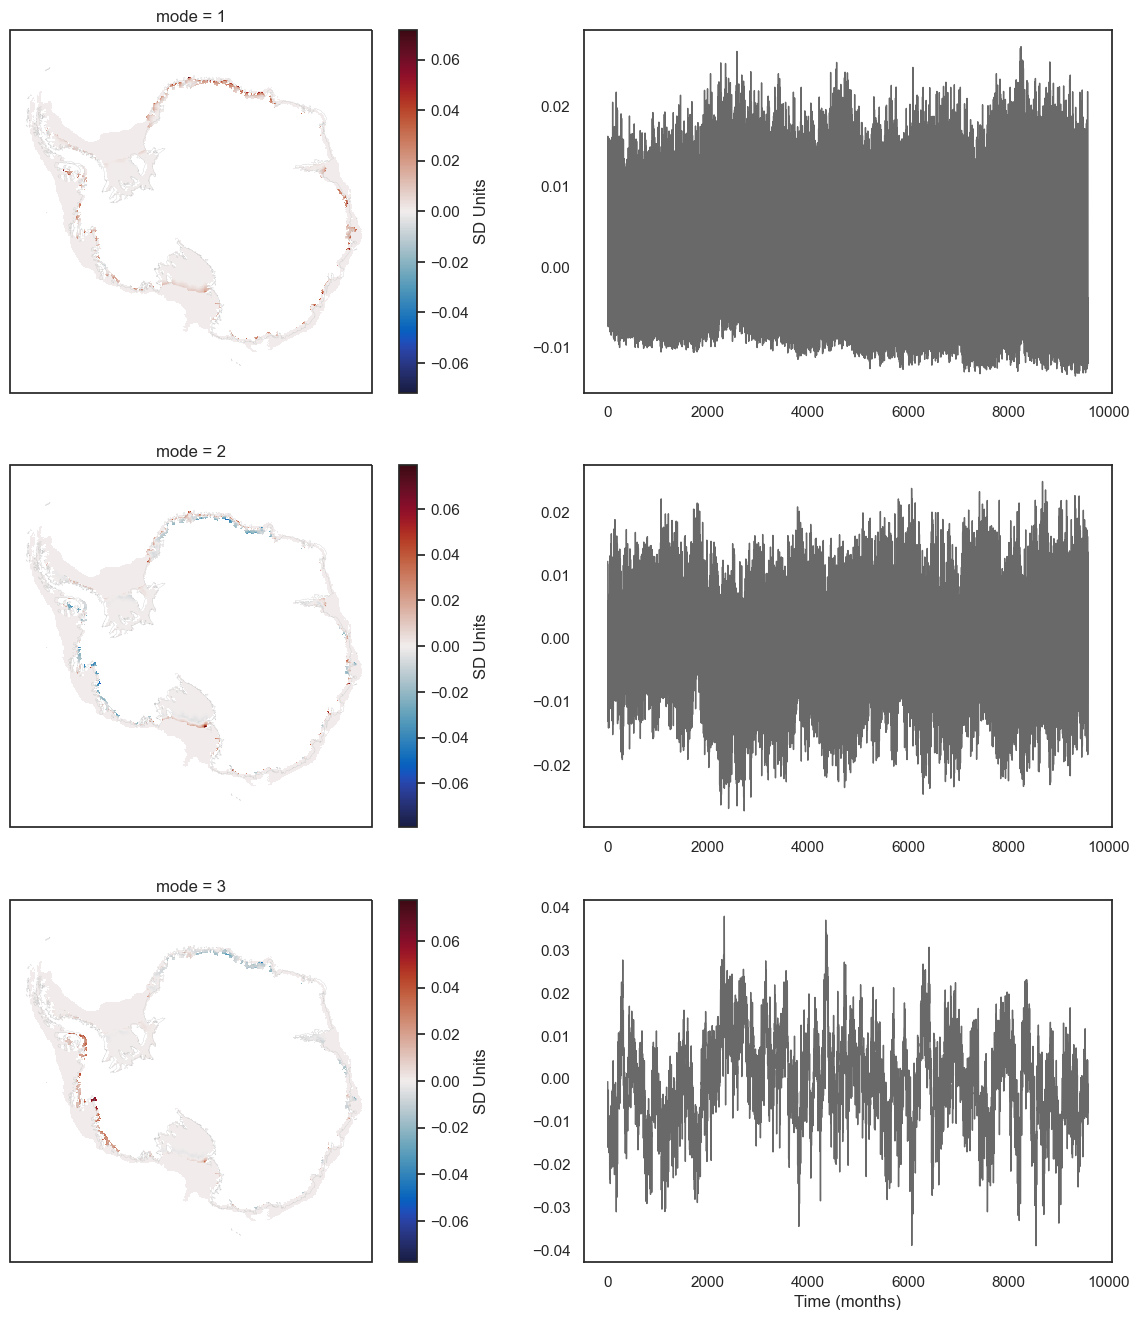

In [22]:
nmodes_plot = 3 # Number of modes to plot
crs = ccrs.SouthPolarStereo();
sns.set_theme(style="white")
fig=plt.figure(figsize=(15,16))
gs = GridSpec(nmodes_plot,2,width_ratios=[2,2])
ax0 = [fig.add_subplot(gs[i, 0],projection=crs) for i in range(nmodes_plot)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(nmodes_plot)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    eofs.sel(mode=i+1).plot(ax=a0,
                                 cmap='cmo.balance',
                                 add_colorbar=True,
                                 cbar_kwargs={'orientation': 'vertical',
                                              'label': 'SD Units'})
    a0.coastlines(resolution='10m',linewidth=0.25,color='0.8')
    a1.plot(pcs.sel(mode=i+1),linewidth=1,color='dimgray')
    a1.set_xlabel('')

a1.set_xlabel('Time (months)');

In [26]:
flux_clean_resample = flux_clean.coarsen(Time=12).mean()

In [36]:
flux_clean_resample_std = flux_clean_resample.std(['Time']).compute()

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


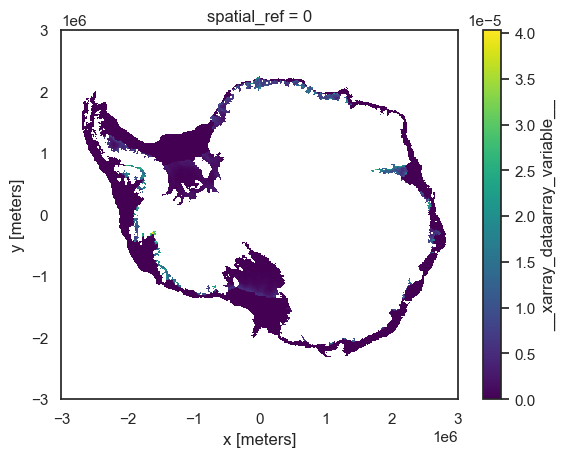

In [37]:
flux_clean_resample_std.plot()

In [ ]:
xr.plot.hist(flux_clean_resample)

In [32]:
flux_clean_resample_ts = flux_clean_resample.mean(['x','y']).compute()

In [9]:
# plt.figure(figsize=(25,8))
# flux_clean_tstd.plot()
#plt.psd(flux_clean_ts);

yr1 = np.arange(0, 500, 50)
yr2 = np.arange(500, 1000, 50)

n_fig = len(yr1)
ncols = 2

fig, axs = plt.subplots(int(n_fig/ncols),ncols, figsize=(5*nrows,10*nrows))
axs = axs.ravel()

for i, (y1, y2) in enumerate(zip(yr1, yr2)):
    freqs, psd = signal.welch(flux_clean_ts[y1*12:y2*12]);
    axs[i].plot(freqs, psd)
    axs[i].set_title("Yrs {} - {}".format(y1,y2))
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

axs[8].set_xlabel('Frequency')
axs[9].set_xlabel('Frequency')






NameError: name 'nrows' is not defined

array([250, 300, 350, 400, 450, 500, 550])

IndexError: index 6 is out of bounds for axis 0 with size 6

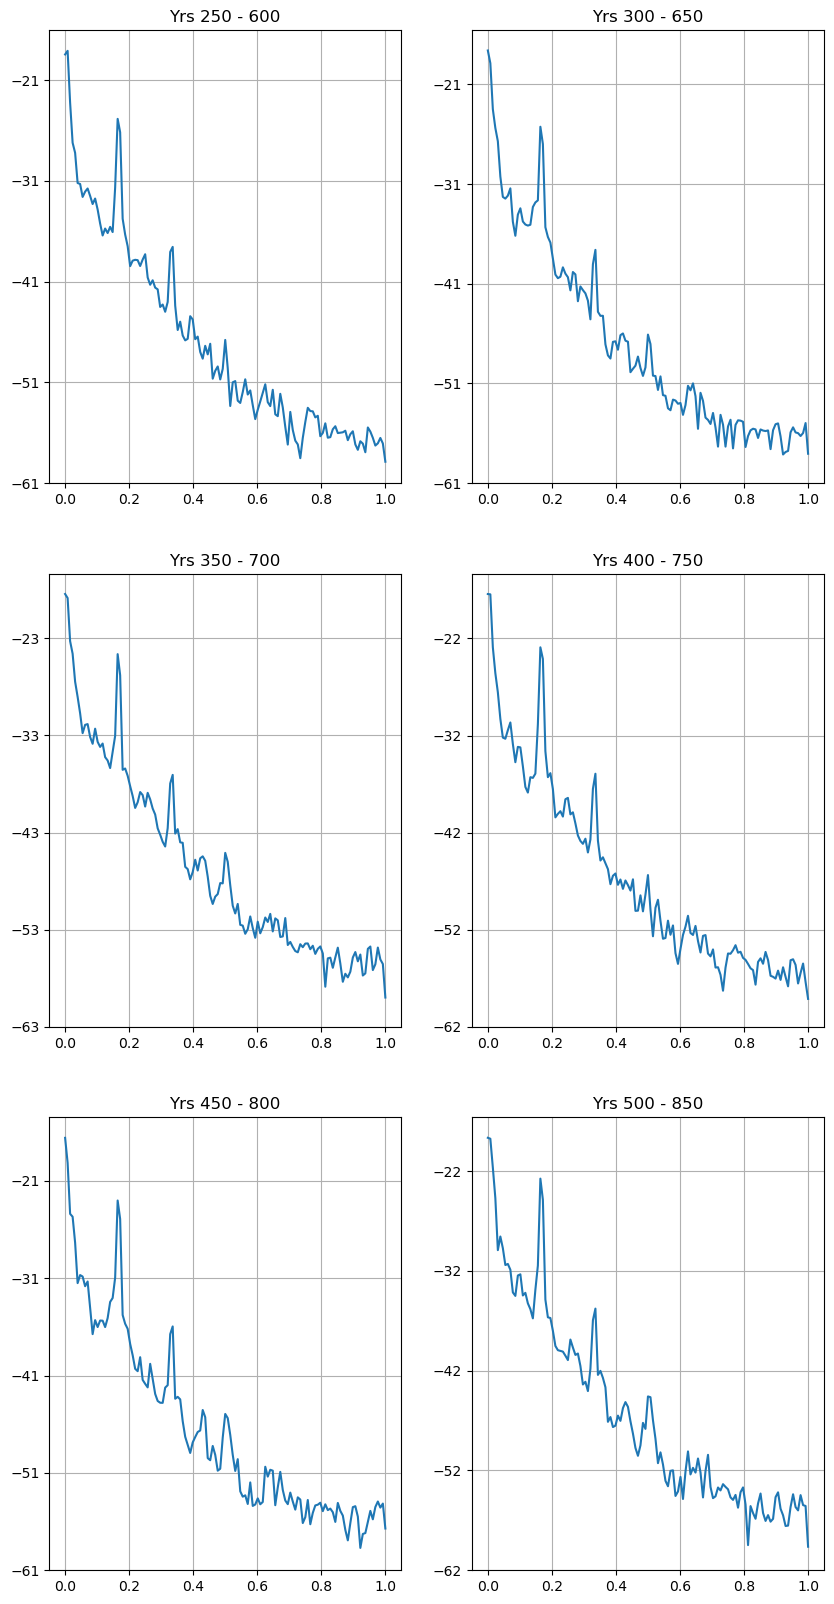

In [ ]:
# plt.figure(figsize=(25,8))
# flux_clean_tstd.plot()
#plt.psd(flux_clean_ts);

yr1 = np.arange(250, 600, 50)
yr2 = np.arange(600, 950, 50)

n_fig = len(yr1)
ncols = 2

fig, axs = plt.subplots(int(n_fig/ncols),ncols, figsize=(5*nrows,10*nrows))
axs = axs.ravel()

for i, (y1, y2) in enumerate(zip(yr1, yr2)):
    axs[i].psd(flux_clean_ts[y1*12:y2*12],Fs=2);
    axs[i].set_title("Yrs {} - {}".format(y1,y2))
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

axs[8].set_xlabel('Frequency')
axs[9].set_xlabel('Frequency')


Text(0.5, 0, 'Time [month]')

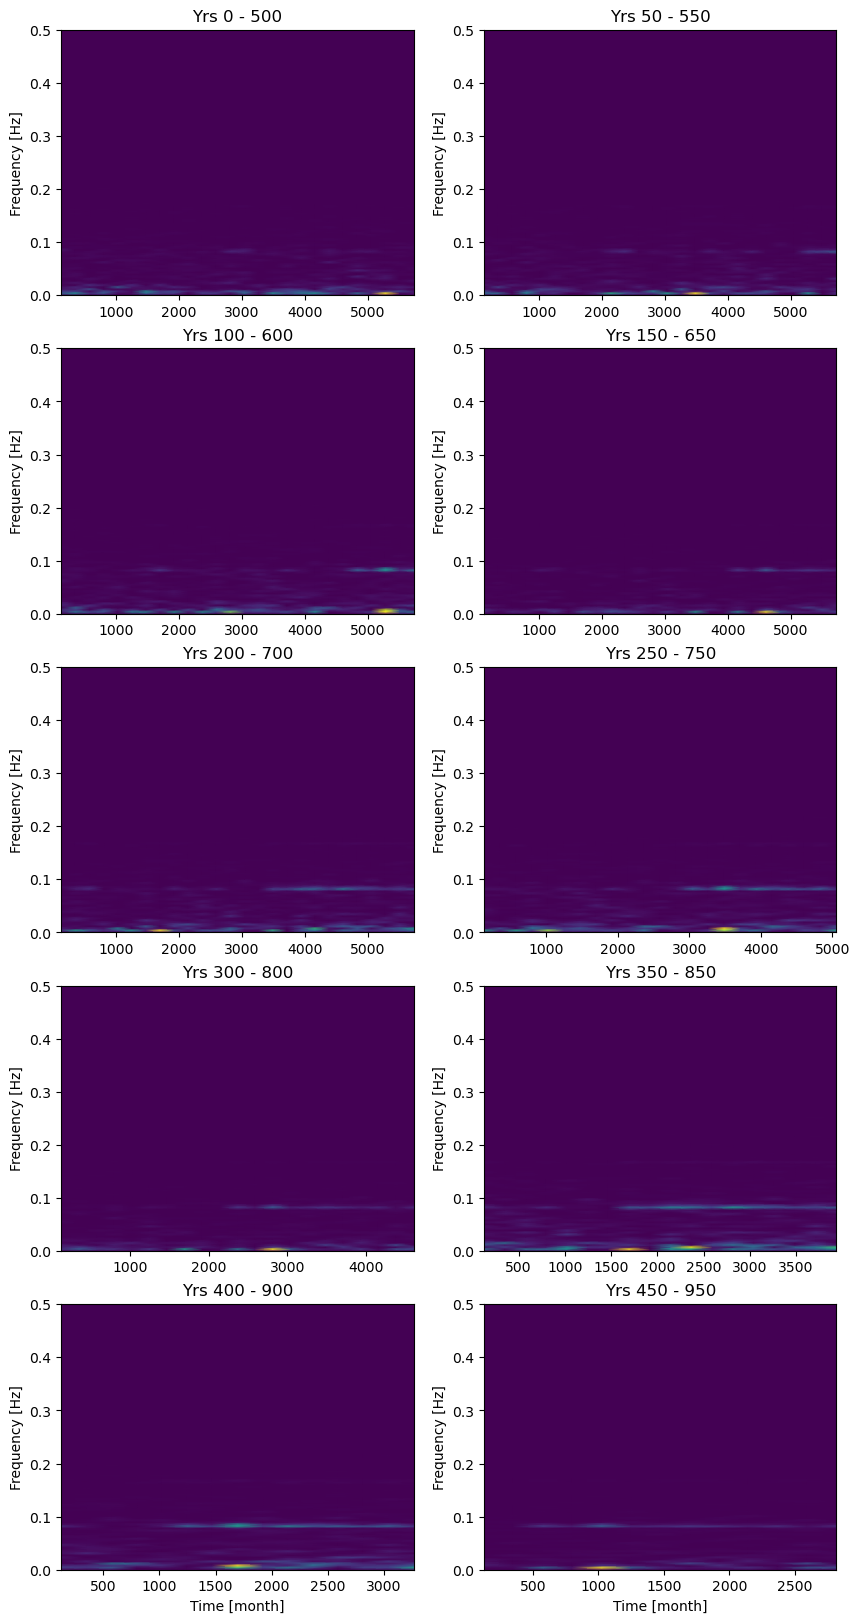

In [ ]:
fig, axs = plt.subplots(int(n_fig/ncols),ncols, figsize=(5*nrows,10*nrows))
axs = axs.ravel()

for i, (y1, y2) in enumerate(zip(yr1, yr2)):
    f, t, Sxx = signal.spectrogram(flux_clean_ts[y1*12:y2*12])
    axs[i].pcolormesh(t, f, Sxx, shading='gouraud')
    axs[i].set_title("Yrs {} - {}".format(y1,y2))
    axs[i].set_ylabel('Frequency [Hz]')
    axs[i].set_xlabel('')

axs[8].set_xlabel('Time [month]')
axs[9].set_xlabel('Time [month]')

Text(0.5, 0, 'Time [month]')

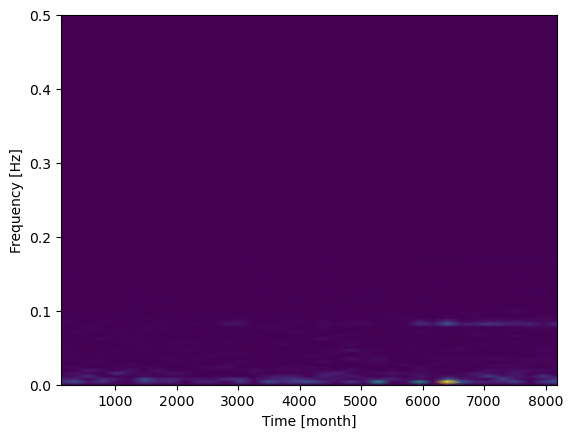

In [ ]:
f, t, Sxx = signal.spectrogram(flux_clean_ts)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [Months]')

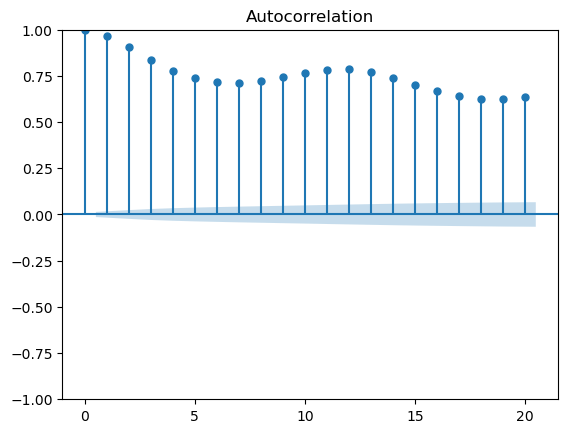

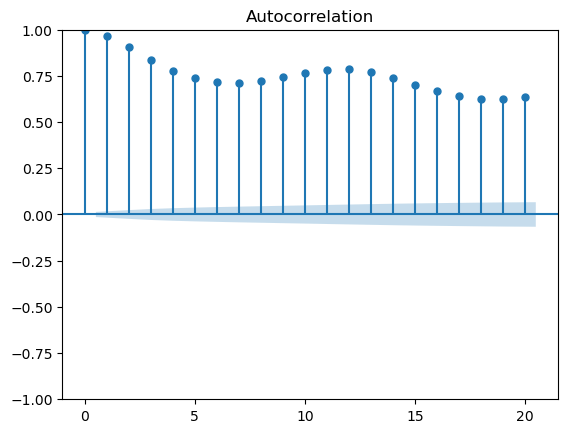

In [ ]:
sm.graphics.tsa.plot_acf(flux_clean_ts, lags=20, alpha=0.2)

In [ ]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(flux_clean_ts)

In [ ]:
results[1]

1.9227598259291344e-07

In [ ]:
results


(-5.972365005729924,
 1.9227598259291344e-07,
 36,
 8363,
 {'1%': -3.4311321724632537,
  '5%': -2.861885666250167,
  '10%': -2.566953993289998},
 -66674.05241837828)

In [ ]:
import pickle
file_pi = open(str(main_dir / "data/interim/SORRMv2.1.ISMF/" / "norm_model.obj"), 'rb') 
norm_model = pickle.load(file_pi)


In [ ]:
pcs = norm_model.pcs()

# Testing for Stationarity

## ADF test

ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. 
The null and alternate hypothesis of this test are:
- Null Hypothesis: The series has a unit root. (possibly non-stationary?)
- Alternate Hypothesis: The series has no unit root.

If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary.

## KPSS test

KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

- Null Hypothesis: The process is trend stationary.
- Alternate Hypothesis: The series has a unit root (series is not stationary).



In [ ]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [ ]:
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [ ]:
adf_test(flux_clean_ts)

Results of Dickey-Fuller Test:
Test Statistic                -5.972365e+00
p-value                        1.922760e-07
#Lags Used                     3.600000e+01
Number of Observations Used    8.363000e+03
Critical Value (1%)           -3.431132e+00
Critical Value (5%)           -2.861886e+00
Critical Value (10%)          -2.566954e+00
dtype: float64


If Test Statistic < Critical Value and P-Value < 0.05, we reject the Null Hypothesis (that series is non-stationary, i.e., has a unit root)
This means above test result supports the alternate hypothesis, that the series is stationary.

In [ ]:
kpss_test(flux_clean_ts)

Results of KPSS Test:
Test Statistic            4.722849
p-value                   0.010000
Lags Used                53.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


The test statistic is greater than the critical values. This automatically reflects in a low p-value. - we can reject the Null Hypothesis of the KPSS test, 

i.e., we can conclude that series is non-stationary.

Literature suggests the the series is difference stationary (ADF stationary and KPSS non-stationary)

### Differencing the time series

In [ ]:
flux_diff_1 = sm.tsa.statespace.tools.diff(flux_clean_ts, k_diff = 1)

In [ ]:
adf_test(flux_diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.877273e+01
p-value                        2.025028e-30
#Lags Used                     3.500000e+01
Number of Observations Used    8.363000e+03
Critical Value (1%)           -3.431132e+00
Critical Value (5%)           -2.861886e+00
Critical Value (10%)          -2.566954e+00
dtype: float64


In [ ]:
kpss_test(flux_diff_1)

Results of KPSS Test:
Test Statistic             0.030367
p-value                    0.100000
Lags Used                250.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


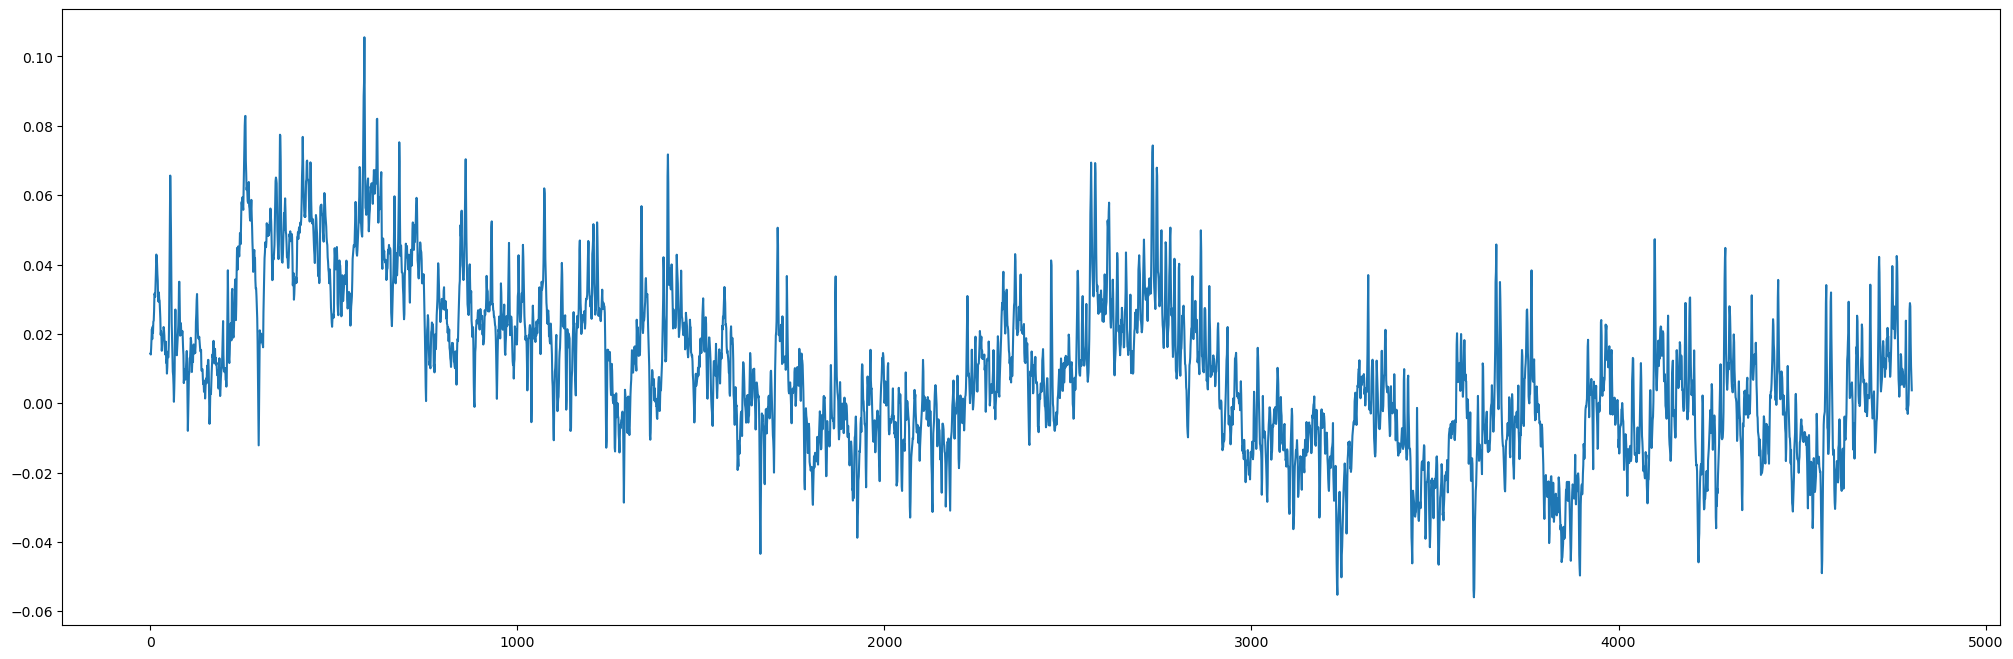

In [ ]:
plt.figure(figsize=(25,8))
#plt.plot(flux_diff_1[:4000])
plt.plot(flux_clean_ts[200:5000])


In [ ]:
flux_diff_clean = flux_clean_ts[1:] - flux_diff_1

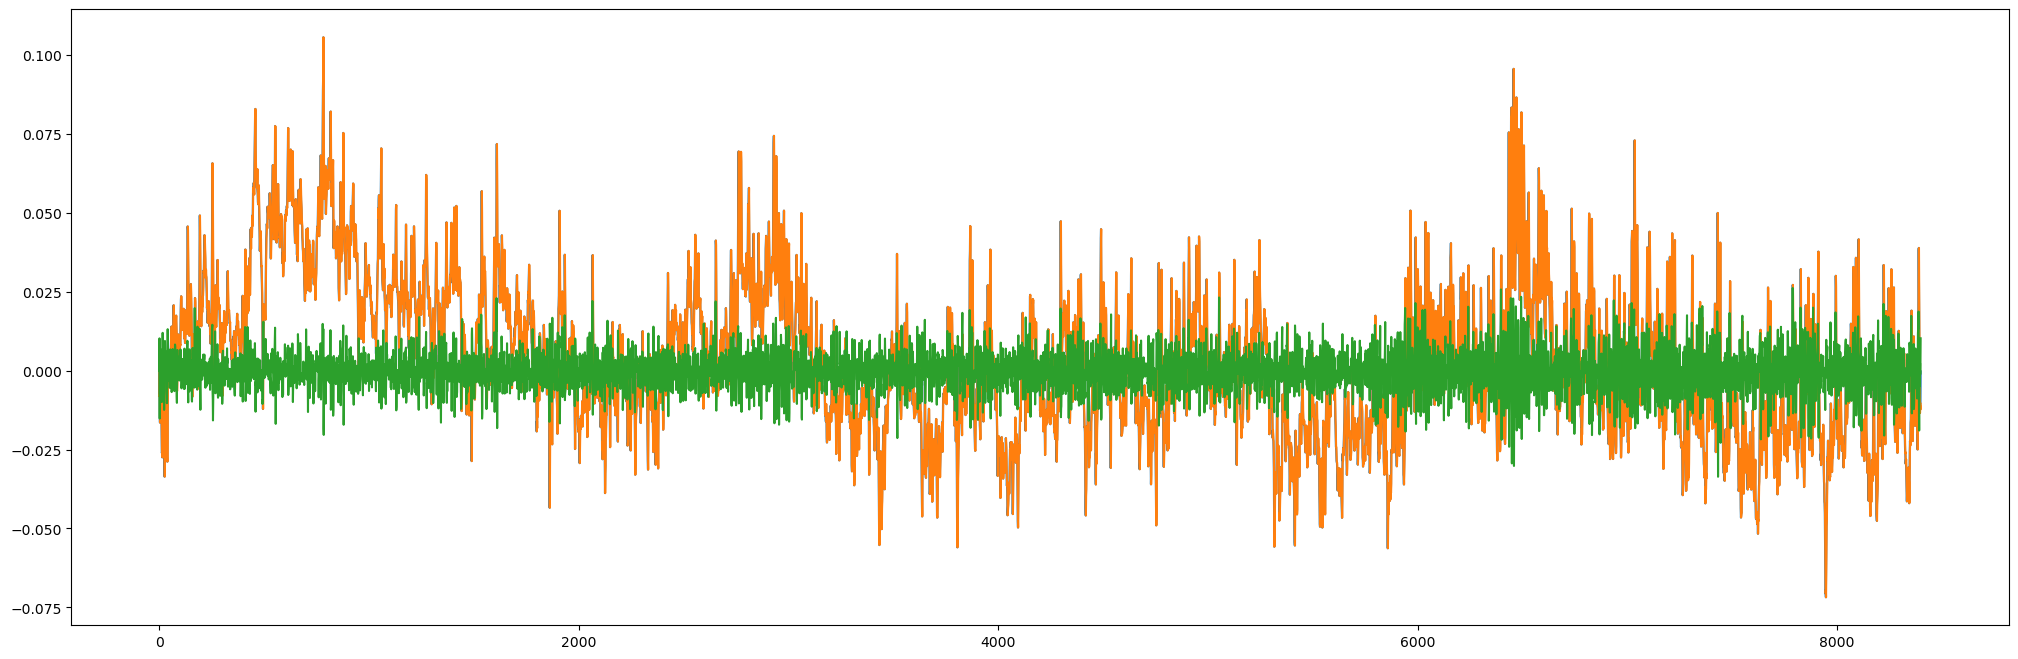

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(flux_clean_ts[1:])
plt.plot(flux_clean_ts[1:] - flux_diff_1)
plt.plot(flux_diff_1)

In [ ]:
# Define number of random Fourier realizations
n_realizations = 2

# Define random number generator 
#rng = np.random.default_rng(2021)
#random_phases = np.exp(np.random.default_rng(2023).uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j) in line 26

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,flux_diff_1.shape[0]-1))

# Time limits for plotting

for i in range(n_realizations):
    fl = flux_diff_1[:] # fluxpcs[:,i] when using PCA outputs
    fl_fourier = np.fft.rfft(fl)
    random_phases = np.exp(np.random.vonmises(0,2*np.pi,int(len(fl)/2+1))*1.0j)
    fl_fourier_new = fl_fourier*random_phases
    new_fl[i,:] = np.fft.irfft(fl_fourier_new)
    print('calculated ifft for realization {}, all modes'.format(i))

calculated ifft for realization 0, all modes
calculated ifft for realization 1, all modes


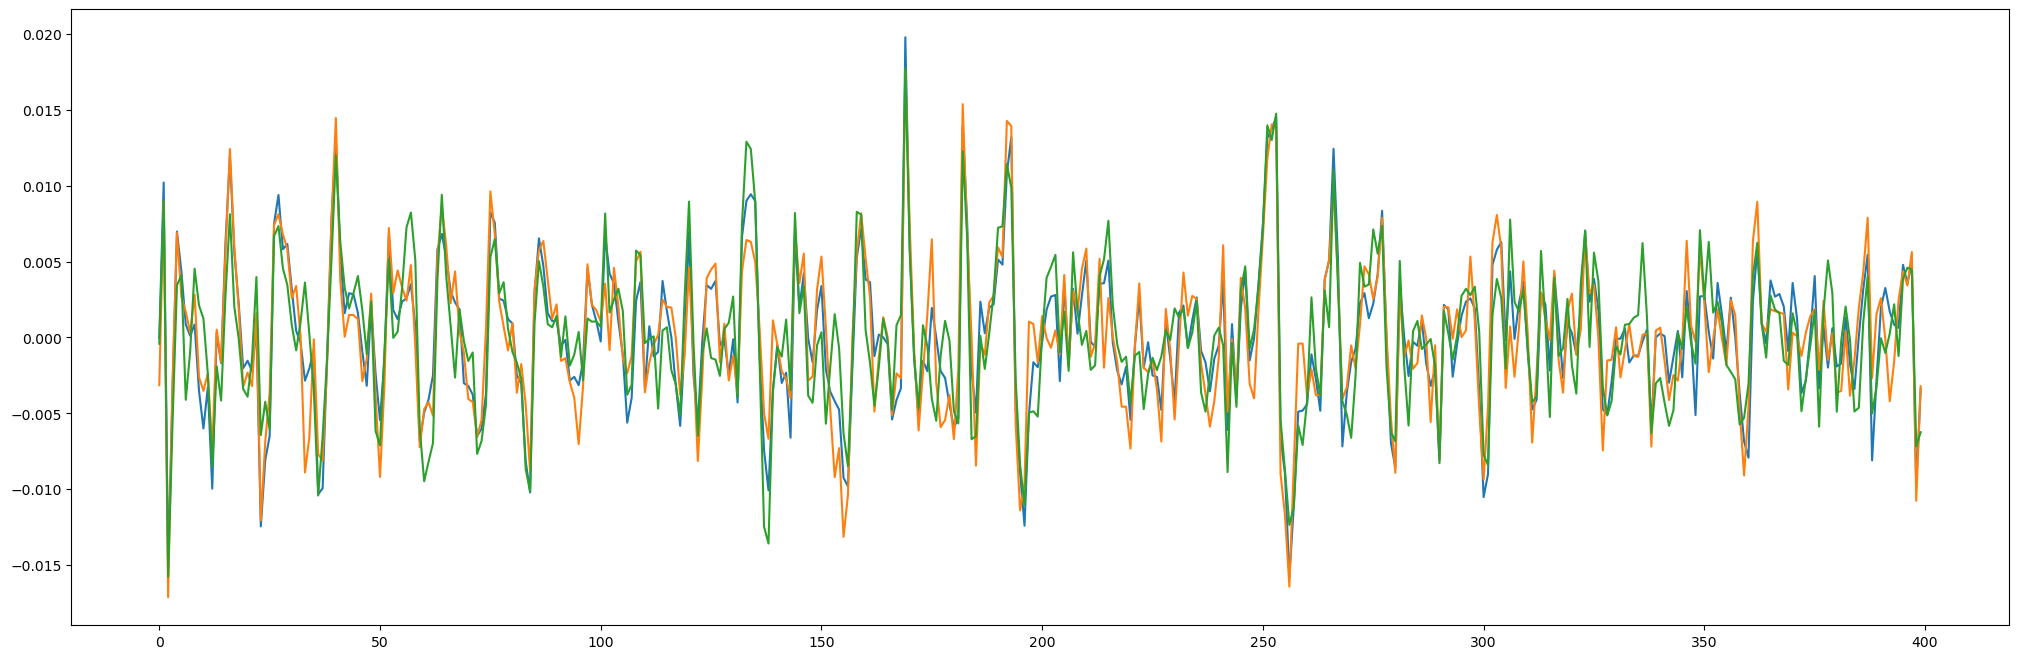

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(flux_diff_1[:400])
plt.plot(new_fl[0,:400])
plt.plot(new_fl[1,:400])

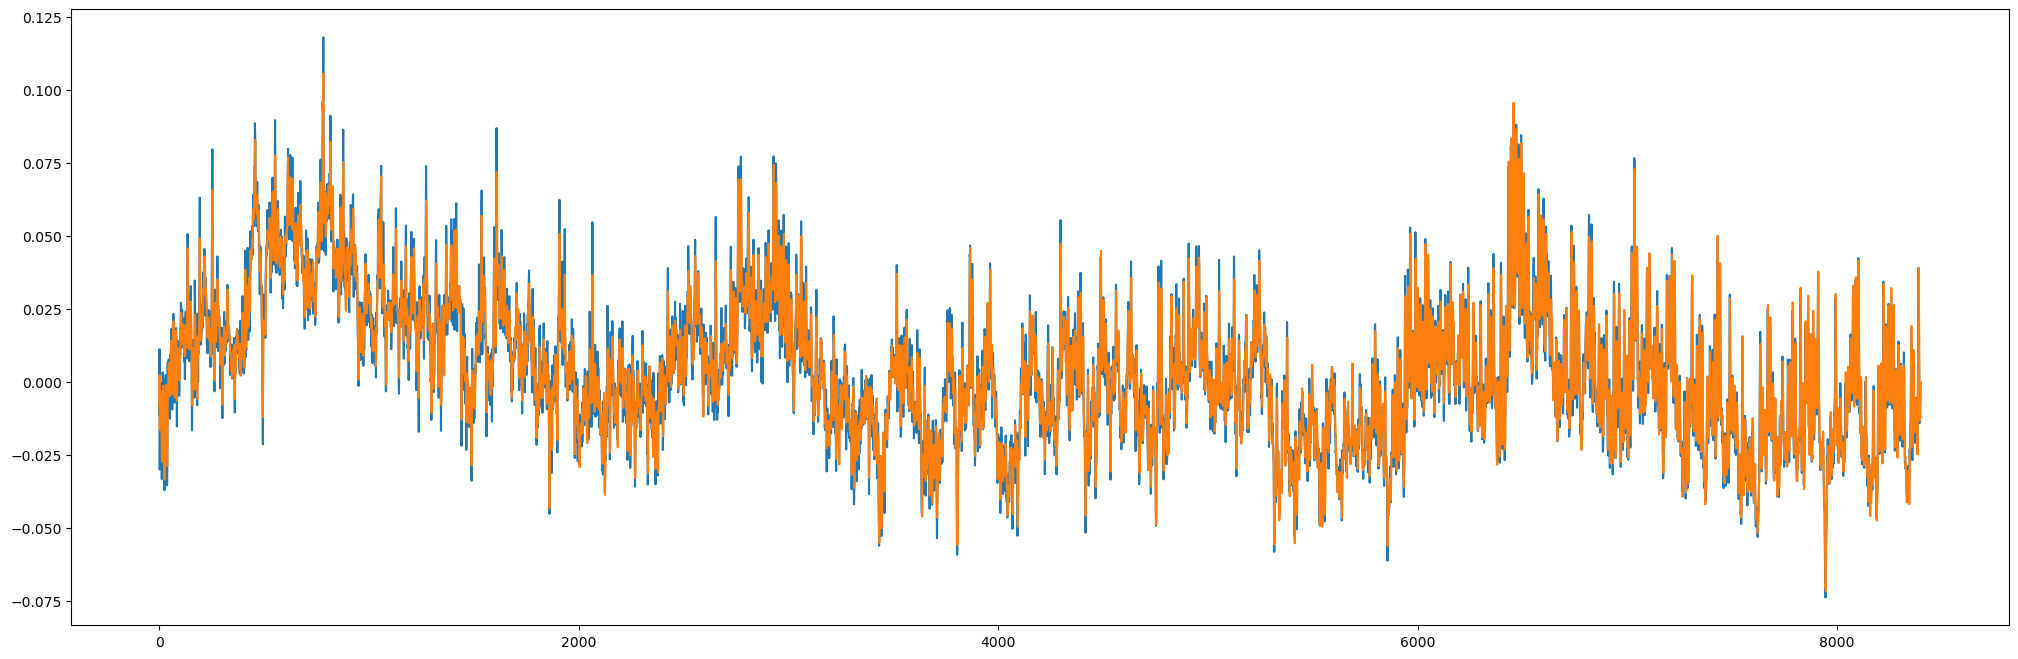

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(new_fl[0,:]+flux_diff_clean[1:])
plt.plot(flux_diff_1+flux_diff_clean)
#plt.plot(new_fl+flux_diff_clean)

In [ ]:
flux_diff_1.shape[0]

8399

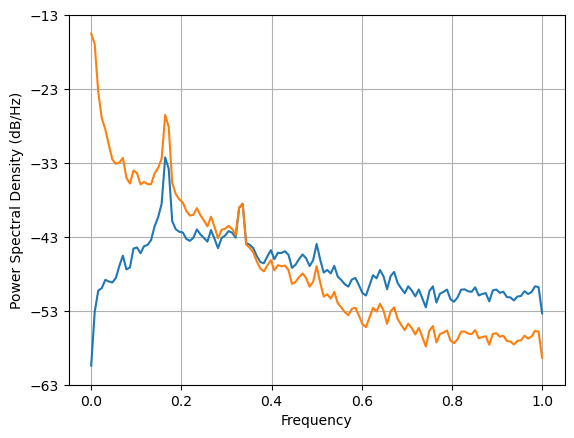

In [ ]:
plt.psd(flux_diff_1);
plt.psd(flux_clean_ts);

Text(0.5, 0, 'Time [Months]')

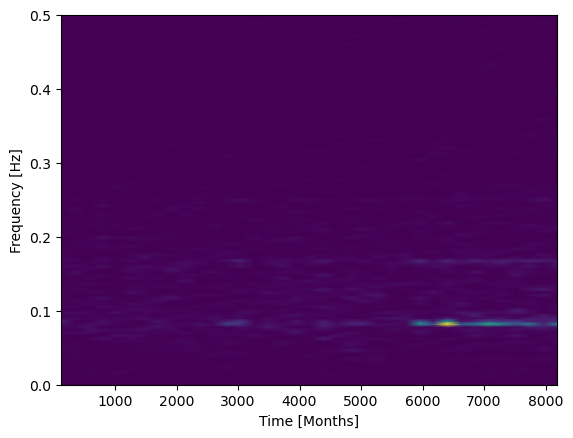

In [ ]:
f, t, Sxx = signal.spectrogram(flux_diff_1)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [Months]')

In [ ]:
# Standard deviation

# Across space
flux_clean_tstd = flux_clean.std(["x","y"]).compute()



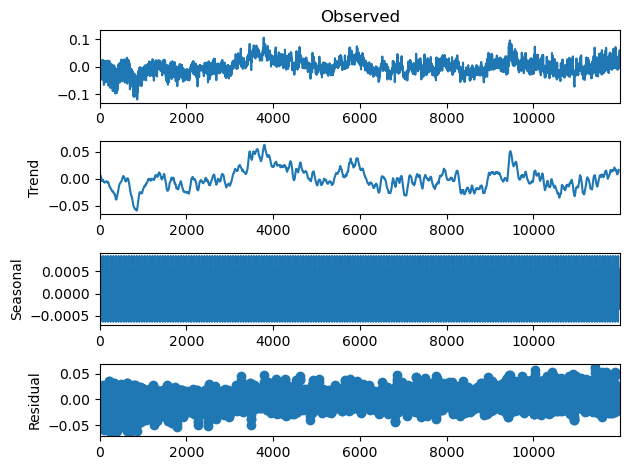

In [ ]:
decompose = seasonal_decompose(flux_clean_ts,model='additive', period=24)
decompose.plot()
plt.show()


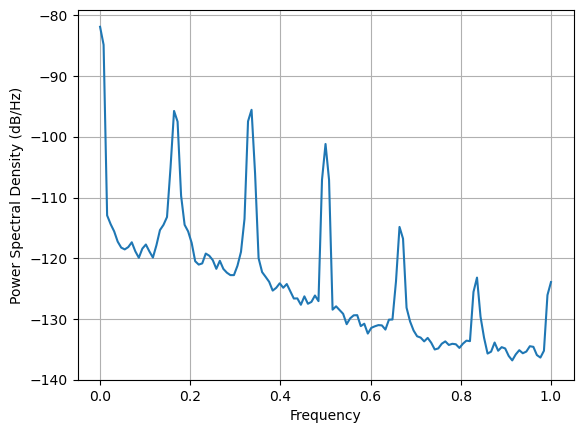

In [ ]:
# Across time
flux_clean_std = flux_clean.std("Time").compute()
flux_clean_std_skipna = flux_clean.std("Time", skipna=True).compute()

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [ ]:
plt.figure(figsize=(15,8))
crs = ccrs.SouthPolarStereo();
flux_clean_std_skipna.where(flux_clean_std_skipna>0).where(flux_clean_std_skipna<0.00006).plot()

NameError: name 'flux_clean_std_skipna' is not defined

<Figure size 1500x800 with 0 Axes>

#### Time series 
Spatially averaged freshwater flux variable is used for analysis. This is across the entire ice sheet domain.

In [ ]:
# Auto-correlation time
fl_fourier = np.fft.rfft(flux_clean_ts)


In [ ]:
fl_fourier

array([ 4.34089392e+01+0.00000000e+00j,  4.02152634e+01-4.21348229e+01j,
        1.11564288e+01-1.71124558e+01j, ...,
       -6.82191708e-02-1.57300157e-01j, -3.38752273e-02+3.63912414e-02j,
       -9.33381623e-02+0.00000000e+00j])

ModuleNotFoundError: No module named 'xrft'

In [ ]:
flux_clean_var = flux_clean.var("Time").compute()

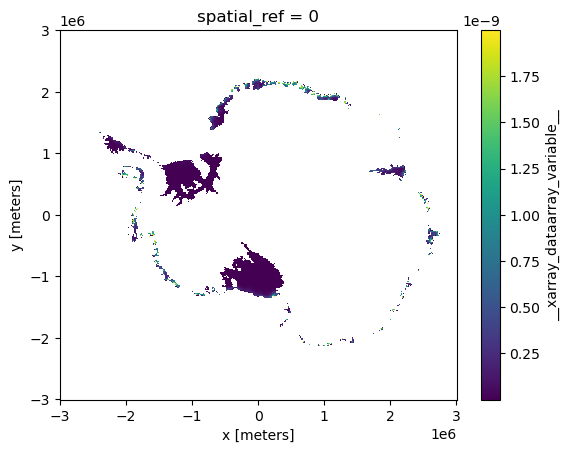

In [ ]:
flux_clean_var.where(flux_clean_var>0).where(flux_clean_var<0.2e-8).plot()